# Project 1 on Machine Learning

## Regression Analysis and Resamping methods

### Part a : Ordinary Least Square (OLS) for the Runge function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def runge_function(x):
    return 1/ (1 + 25 * x**2)

def runge_noisy(x, noise = 0.1):
    return runge_function(x) + np.random.normal(0, noise, size = x.shape)

In [2]:
n_points = 100
x = np.linspace(-1, 1, n_points).reshape(-1, 1)

y_true = runge_function(x).ravel()

y = runge_noisy(x, noise = 0.1).ravel()

def design_matrix(x, degree):
    X = np.ones((x.shape[0], 1))
    for d in range(1, degree+1):
        X = np.hstack((X, x**d))
    return X

def ols_fit(X, y):
    beta = np.linalg.pinv(X.T @ X) @ X.T @ y
    return beta

def predict(X, beta):
    return X @ beta

Text(0.5, 1.0, 'R² vs Polynomial Degree')

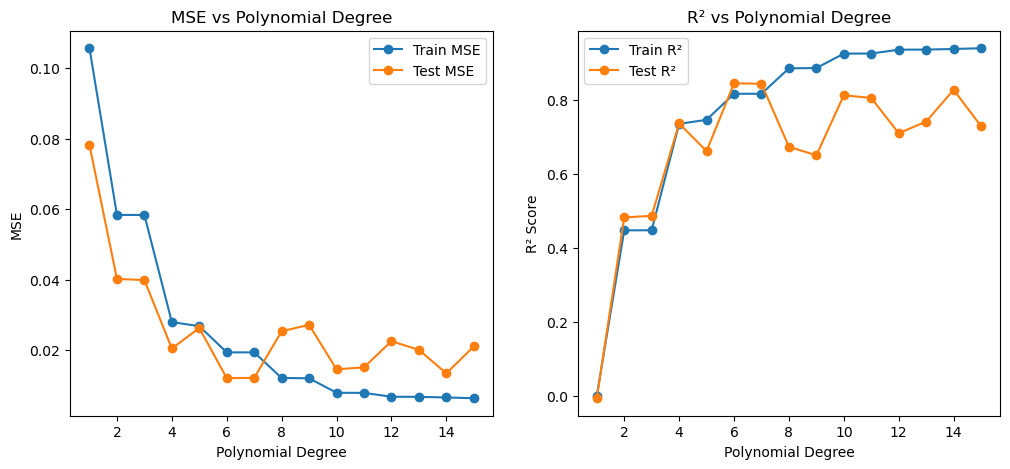

In [3]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def r2_value(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

degrees = range(1, 16)
mse_train, mse_test, r2_train, r2_test = [], [], [], []

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test = design_matrix(x_test_scaled, d)
    
    beta = ols_fit(X_train, y_train)
    
    y_train_pred = predict(X_train, beta)
    y_test_pred = predict(X_test, beta)
    
    mse_train.append(mse(y_train, y_train_pred))
    mse_test.append(mse(y_test, y_test_pred))
    r2_train.append(r2_value(y_train, y_train_pred))
    r2_test.append(r2_value(y_test, y_test_pred))
    
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, mse_train, 'o-', label = "Train MSE")
plt.plot(degrees, mse_test, 'o-', label = "Test MSE")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE vs Polynomial Degree")

plt.subplot(1, 2, 2)
plt.plot(degrees, r2_train, 'o-', label = "Train R²")
plt.plot(degrees, r2_test, 'o-', label = "Test R²")
plt.xlabel("Polynomial Degree")
plt.ylabel("R² Score")
plt.legend()
plt.title("R² vs Polynomial Degree")


Data scaling is particularly important when working with high-degree polynomials, since their values can grow exponentially. In order to address this, we applied StandardScaler to x in our code. When x lies between −1 and 1, higher powers do not change its value significantly. However, after performing a train-test split, differences in scale and noise may arise. Scaling ensures that all features remain on a comparable range. This step becomes even more critical for regularisation methods, which we will discuss later, because their penalty terms are directly influenced by feature magnitudes.

### Part b: Adding Ridge regression for the Runge function

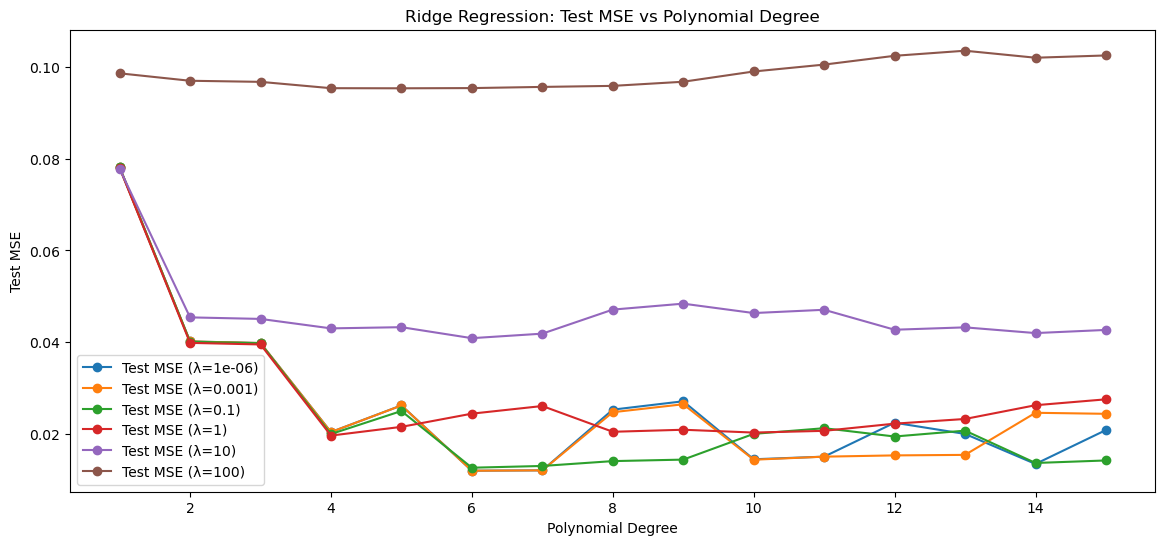

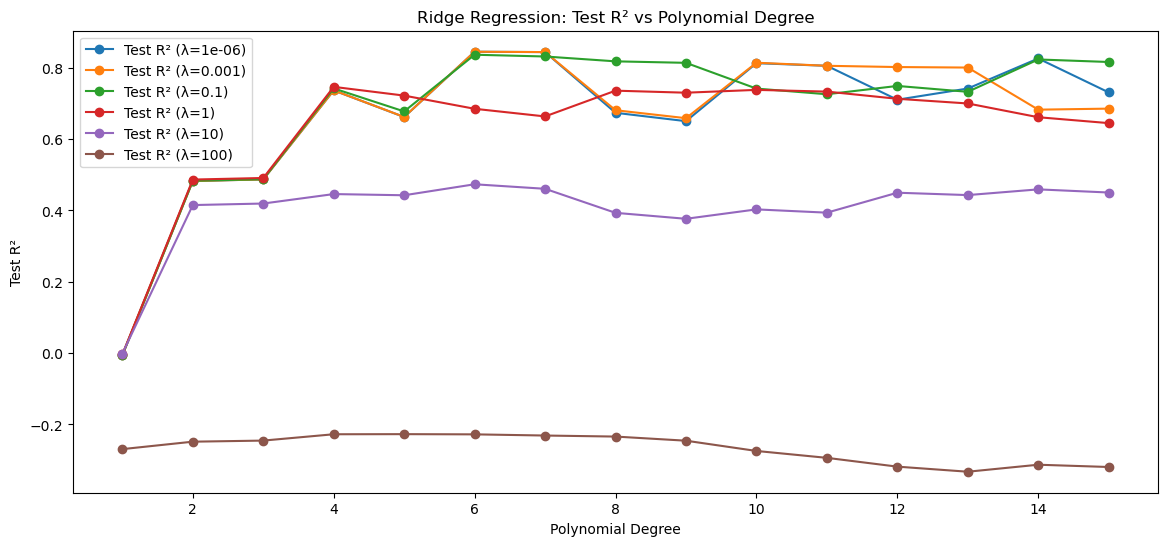

In [4]:
def ridge_reg(X, y, lam):
    n_features = X.shape[1]
    I = np.eye(n_features)
    beta = np.linalg.pinv(X.T @ X + lam * I) @ X.T @ y
    return beta

degrees = range(1, 16)
lambdas = [1e-6, 1e-3, 1e-1, 1, 10, 100]

results = {}

for lam in lambdas:
    mse_train, mse_test, r2_train, r2_test = [], [], [], []
    
    for d in degrees:
        X_train = design_matrix(x_train_scaled, d)
        X_test = design_matrix(x_test_scaled, d)
        
        beta = ridge_reg(X_train, y_train, lam)
        y_train_pred = predict(X_train, beta)
        y_test_pred = predict(X_test, beta)
        
        mse_train.append(mse(y_train, y_train_pred))
        mse_test.append(mse(y_test, y_test_pred))
        r2_train.append(r2_value(y_train, y_train_pred))
        r2_test.append(r2_value(y_test, y_test_pred))
        
    results[lam] = {
        "mse_train": mse_train,
        "mse_test": mse_test,
        "r2_train": r2_train,
        'r2_test': r2_test
    }
    
plt.figure(figsize = (14, 6))

for lam in lambdas:
    plt.plot(degrees, results[lam]["mse_test"], 'o-', label = f"Test MSE (λ={lam})")

plt.xlabel("Polynomial Degree")
plt.ylabel("Test MSE")
plt.title("Ridge Regression: Test MSE vs Polynomial Degree")
plt.legend()
plt.show()

plt.figure(figsize = (14, 6))
for lam in lambdas:
    plt.plot(degrees, results[lam]["r2_test"], 'o-', label = f"Test R² (λ={lam})")
    
plt.xlabel("Polynomial Degree")
plt.ylabel("Test R²")
plt.title("Ridge Regression: Test R² vs Polynomial Degree")
plt.legend()
plt.show()
    

When lambda = 0, ridge regression produces results equivalent to OLS. For very small values of lambda (e.g., 
1e−6, 1e−3), the results remain similar to OLS, but with slightly greater stability at higher polynomial degrees. With moderate values of lambda (e.g., 0.1, 1), ridge regression reduces variance, leading to less overfitting and lower error compared to OLS. However, for large values of lambda (e.g., 10, 100), underfitting occurs: R² decreases and test MSE increases. This behavior illustrates the bias–variance tradeoff: while OLS tends to overfit at high polynomial degrees, ridge regression stabilises solutions by penalising large coefficients.

### Part c: Forming Gradient Descent

In [5]:
def gd_ols_fixed(X, y, gamma=1e-3, max_iters=200000, grad_tol=1e-8, theta0=None):
    n, p = X.shape
    theta = np.random.randn(p) if theta0 is None else theta0.copy()

    history = {"loss": [], "grad_norm": []}

    for _ in range(max_iters):
        # gradient and loss
        r = X @ theta - y                           # residuals
        grad = (2.0 / n) * (X.T @ r)                # gradient C(theta)
        grad_norm = np.linalg.norm(grad)
        loss = (r @ r) / n                          # C(theta)

        history["loss"].append(loss)
        history["grad_norm"].append(grad_norm)

        if grad_norm <= grad_tol:                   # early stop criteria
            break

        # update
        theta = theta - gamma * grad

    return theta, history

comments: implementation of simple GD with fixed learning rate $\gamma$

/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_69115/105864795.py:12: RuntimeWarning: overflow encountered in matmul
  loss = (r @ r) / n                          # C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_69115/105864795.py:10: RuntimeWarning: overflow encountered in matmul
  grad = (2.0 / n) * (X.T @ r)                # gradient C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_69115/105864795.py:10: RuntimeWarning: invalid value encountered in matmul
  grad = (2.0 / n) * (X.T @ r)                # gradient C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_69115/105864795.py:21: RuntimeWarning: invalid value encountered in subtract
  theta = theta - gamma * grad
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_69115/105864795.py:9: RuntimeWarning: invalid value encountered in matmul
  r = X @ theta - y                           # residuals


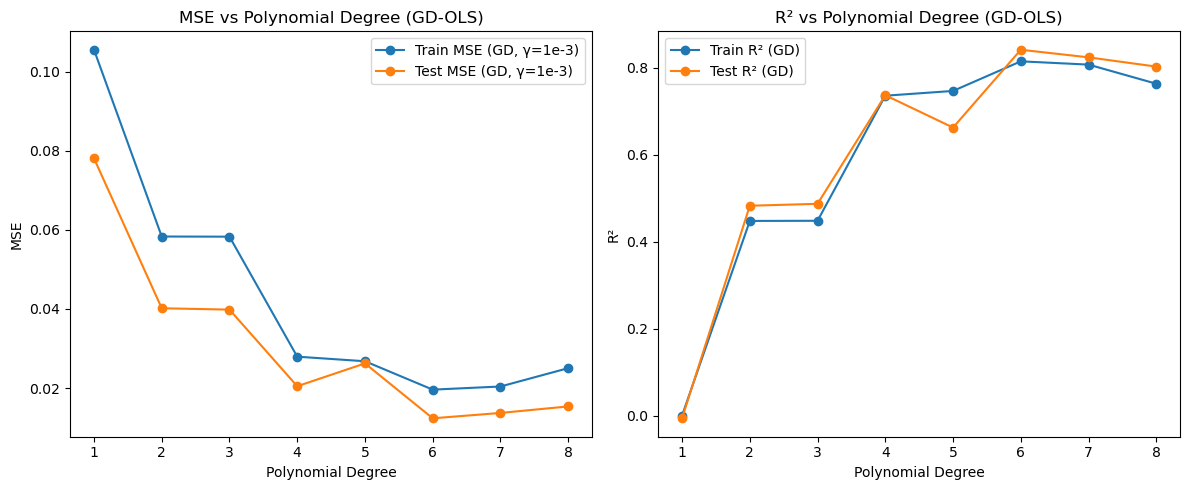

In [6]:
degrees = range(1, 16)
gamma = 1e-3          # constant learning rate
grad_tol = 1e-8

mse_train_gd, mse_test_gd, r2_train_gd, r2_test_gd = [], [], [], []

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test  = design_matrix(x_test_scaled,  d)

    beta_gd, hist = gd_ols_fixed(X_train, y_train, gamma=gamma, grad_tol=grad_tol)

    ytr_hat = predict(X_train, beta_gd)
    yte_hat = predict(X_test,  beta_gd)

    mse_train_gd.append(mse(y_train, ytr_hat))
    mse_test_gd.append(mse(y_test,  yte_hat))
    r2_train_gd.append(r2_value(y_train, ytr_hat))
    r2_test_gd.append(r2_value(y_test,  yte_hat))

# plots for Part (c)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(degrees, mse_train_gd, 'o-', label='Train MSE (GD, γ=1e-3)')
plt.plot(degrees, mse_test_gd,  'o-', label='Test MSE (GD, γ=1e-3)')
plt.xlabel("Polynomial Degree"); plt.ylabel("MSE"); plt.title("MSE vs Polynomial Degree (GD-OLS)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(degrees, r2_train_gd, 'o-', label='Train R² (GD)')
plt.plot(degrees, r2_test_gd,  'o-', label='Test R² (GD)')
plt.xlabel("Polynomial Degree"); plt.ylabel("R²"); plt.title("R² vs Polynomial Degree (GD-OLS)")
plt.legend(); plt.tight_layout(); plt.show()


comment: repeat of parts a and b. MSE and R^2 of each poly degree

In part c, we replaced the analytic solution of OLS with our own GD implementation with a fixed learning rate $\gamma$. The graphs plotted, namely MSE and R^2 against polynomial degree shows that the GD-based OLS generally produces the same trend as in that in part a. MSE and R^2 decreases adn increases respectively with polynomial degree. Convergence was achieved up to degree 8, after which, GD with $\gamma$ = 10^-3 did not converge reliably within the iteration budget. This highlights the sensitivity of GD to both learning rate and polynomial degree, as higher-degree design matrices amplify instability.

/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_69115/105864795.py:12: RuntimeWarning: overflow encountered in matmul
  loss = (r @ r) / n                          # C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_69115/105864795.py:10: RuntimeWarning: overflow encountered in matmul
  grad = (2.0 / n) * (X.T @ r)                # gradient C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_69115/105864795.py:10: RuntimeWarning: invalid value encountered in matmul
  grad = (2.0 / n) * (X.T @ r)                # gradient C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_69115/105864795.py:21: RuntimeWarning: invalid value encountered in subtract
  theta = theta - gamma * grad


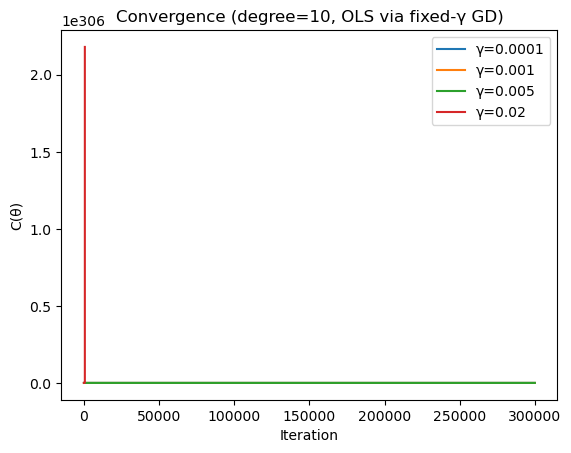

In [7]:
d = 6
Xtr = design_matrix(x_train_scaled, d)

for g in [1e-4, 1e-3, 5e-3, 2e-2]:
    _, h = gd_ols_fixed(Xtr, y_train, gamma=g, grad_tol=1e-10, max_iters=300000)
    plt.plot(h["loss"], label=f"γ={g}")
plt.xlabel("Iteration"); plt.ylabel("C(θ)"); plt.title("Convergence (degree=10, OLS via fixed-γ GD)")
plt.legend(); plt.show()


comments: convergence plot 

Figure Y illustrates the convergence behavior for different learning rates at degree 10. With small γ values (blue, yellow and green line), the algorithm converges steadily, though the speed varies. At $\gamma$ = 10^-3, the yellow line, GD converges efficiently to a solution comparable to the closed-form OLS, confirming that GD can approximate the analytic optimum when tuned appropriately. However, at $\gamma$ = 0.02 the updates overshoot, causing the cost function to diverge immediately to extremely large values, dominating the plot.

These results underline that while GD provides a flexible, iterative alternative to the analytic OLS solution, its success depends critically on the choice of learning rate. Too small a $\gamma$ leads to slow convergence, while too large a $\gamma$ causes divergence. The inability to stably reach solutions at higher polynomial degrees further emphasizes this sensitivity, motivating the use of more advanced optimizers with momentum or adaptive learning rates, as explored in Part (d).

### Part d: Using momentum, ADAgrad, RMSprop and ADAM to update learning rate

#### Momentum

In [8]:
def gd_momentum_batch(X, y, eta=1e-2, mu=0.9, max_iters=20000, grad_tol=1e-8,
                      lam=0.0, regularize_bias=False, theta0=None):
    n, p = X.shape
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    v = np.zeros_like(theta)

    def grad(th):
        g = (2.0/n) * (X.T @ (X @ th - y))
        if lam != 0:
            if regularize_bias: g += 2.0*lam*th
            else:               g[1:] += 2.0*lam*th[1:]
        return g

    history = {"loss": [], "grad_norm": []}
    for _ in range(max_iters):
        r = y - X @ theta
        loss = (r @ r)/n + (0 if lam==0 else lam*(theta@theta if regularize_bias else theta[1:]@theta[1:]))
        g = grad(theta); gn = np.linalg.norm(g)
        history["loss"].append(loss); history["grad_norm"].append(gn)
        if gn <= grad_tol: break
        v = mu*v + eta*g
        theta = theta - v
    return theta, history


#### AdaGrad

In [9]:
def adagrad_batch(X, y, eta=1e-2, delta=1e-8, max_iters=20000, grad_tol=1e-8,
                  lam=0.0, regularize_bias=False, theta0=None):
    n, p = X.shape
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    r = np.zeros(p)

    def grad(th):
        g = (2.0/n) * (X.T @ (X @ th - y))
        if lam != 0:
            if regularize_bias: g += 2.0*lam*th
            else:               g[1:] += 2.0*lam*th[1:]
        return g

    history = {"loss": [], "grad_norm": []}
    for _ in range(max_iters):
        rvec = y - X @ theta
        loss = (rvec @ rvec)/n + (0 if lam==0 else lam*(theta@theta if regularize_bias else theta[1:]@theta[1:]))
        g = grad(theta); gn = np.linalg.norm(g)
        history["loss"].append(loss); history["grad_norm"].append(gn)
        if gn <= grad_tol: break
        r += g*g
        step = (eta / (delta + np.sqrt(r))) * g
        theta -= step
    return theta, history


#### RMSProp

In [10]:
def rmsprop_batch(X, y, eta=1e-3, rho=0.9, delta=1e-8, max_iters=20000, grad_tol=1e-8,
                  lam=0.0, regularize_bias=False, theta0=None):
    n, p = X.shape
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    r = np.zeros(p)

    def grad(th):
        g = (2.0/n) * (X.T @ (X @ th - y))
        if lam != 0:
            if regularize_bias: g += 2.0*lam*th
            else:               g[1:] += 2.0*lam*th[1:]
        return g

    history = {"loss": [], "grad_norm": []}
    for _ in range(max_iters):
        rvec = y - X @ theta
        loss = (rvec @ rvec)/n + (0 if lam==0 else lam*(theta@theta if regularize_bias else theta[1:]@theta[1:]))
        g = grad(theta); gn = np.linalg.norm(g)
        history["loss"].append(loss); history["grad_norm"].append(gn)
        if gn <= grad_tol: break
        r = rho*r + (1.0 - rho)*(g*g)
        step = (eta / (delta + np.sqrt(r))) * g
        theta -= step
    return theta, history


#### ADAM

In [11]:
def adam_batch(X, y, eta=1e-3, beta1=0.9, beta2=0.999, delta=1e-8,
               max_iters=20000, grad_tol=1e-8, lam=0.0, regularize_bias=False, theta0=None):
    n, p = X.shape
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    m = np.zeros(p); v = np.zeros(p)
    t = 0

    def grad(th):
        g = (2.0/n) * (X.T @ (X @ th - y))
        if lam != 0:
            if regularize_bias: g += 2.0*lam*th
            else:               g[1:] += 2.0*lam*th[1:]
        return g

    history = {"loss": [], "grad_norm": []}
    for _ in range(max_iters):
        rvec = y - X @ theta
        loss = (rvec @ rvec)/n + (0 if lam==0 else lam*(theta@theta if regularize_bias else theta[1:]@theta[1:]))
        g = grad(theta); gn = np.linalg.norm(g)
        history["loss"].append(loss); history["grad_norm"].append(gn)
        if gn <= grad_tol: break
        t += 1
        m = beta1*m + (1.0 - beta1)*g
        v = beta2*v + (1.0 - beta2)*(g*g)
        mhat = m / (1.0 - beta1**t)
        vhat = v / (1.0 - beta2**t)
        step = eta * mhat / (np.sqrt(vhat) + delta)
        theta -= step
    return theta, history


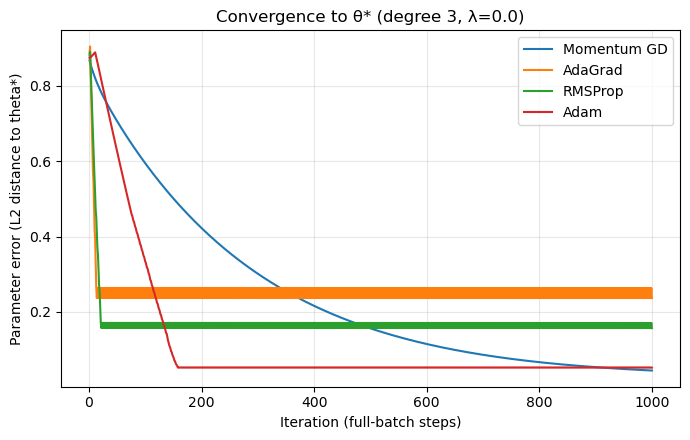

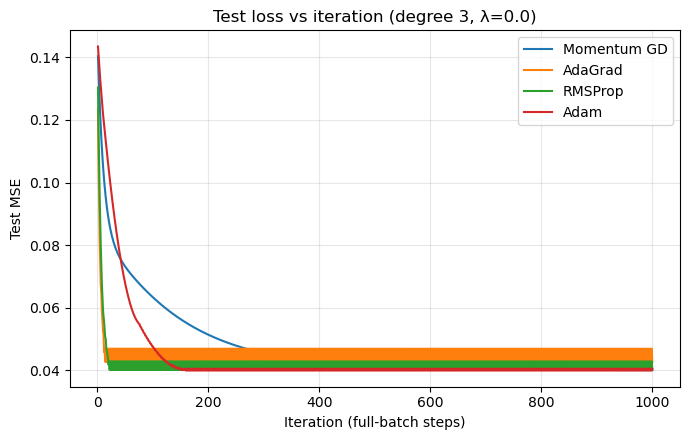

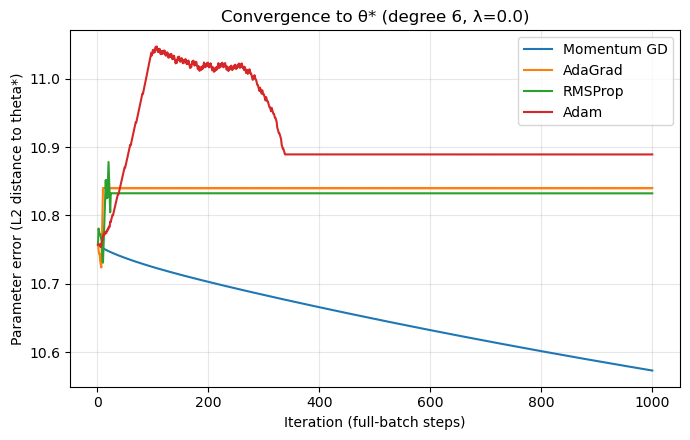

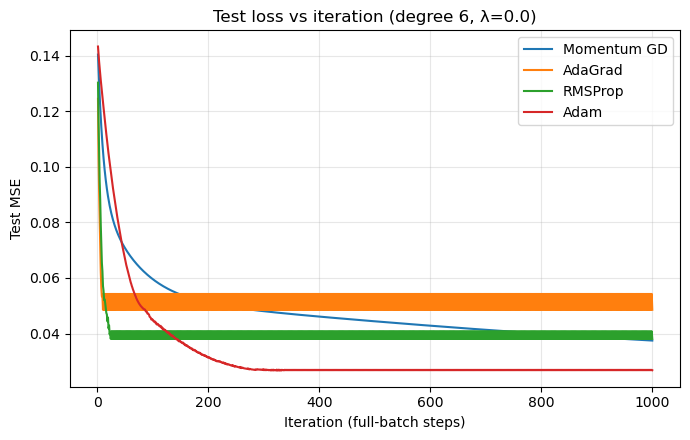

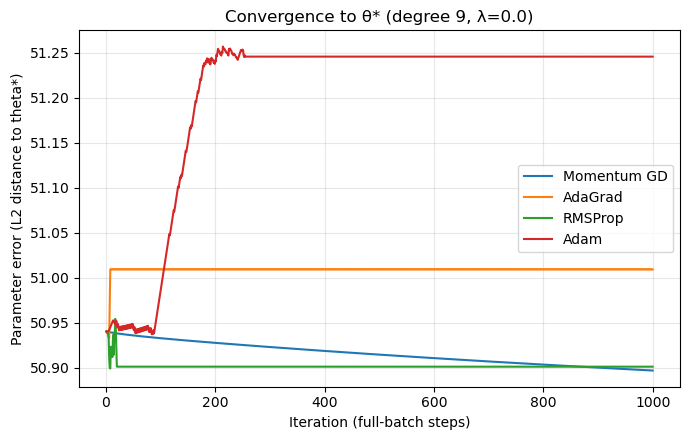

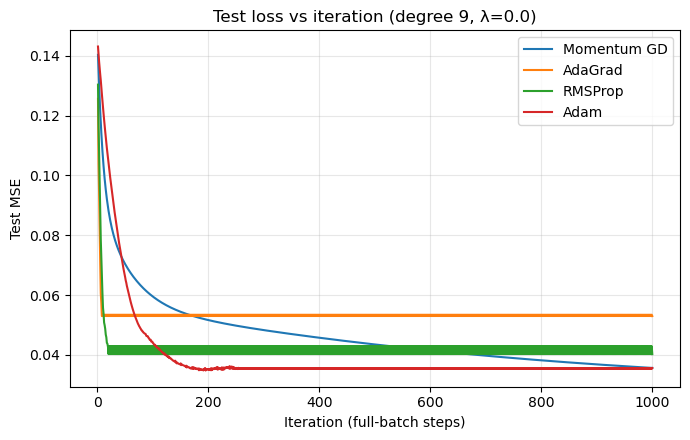

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# --- where to save ---
OUTDIR = "figures"
os.makedirs(OUTDIR, exist_ok=True)

# --- closed-form optimum matching your objective (on TRAIN split) ---
def closed_form_optimum(X, y, lam=0.0, regularize_bias=False):
    n, p = X.shape
    A = X.T @ X
    I = np.eye(p)
    if not regularize_bias:
        I[0, 0] = 0.0
    return np.linalg.solve(A + (n * lam) * I, X.T @ y)

# --- run any of your optimizers step-by-step (no edits needed) ---
def run_with_tracking(optimizer_fn, X, y, T=1000, theta0=None, **kwargs):
    n, p = X.shape
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    thetas, losses, grad_norms = [], [], []
    for _ in range(T):
        theta, hist = optimizer_fn(
            X, y,
            max_iters=1,
            grad_tol=0.0,
            theta0=theta,
            **kwargs
        )
        thetas.append(theta.copy())
        losses.append(hist["loss"][-1] if hist["loss"] else np.nan)
        grad_norms.append(hist["grad_norm"][-1] if hist["grad_norm"] else np.nan)
    return {
        "theta_path": np.array(thetas),
        "loss": np.array(losses),
        "grad_norm": np.array(grad_norms),
        "theta_final": theta,
    }

# ------------------ experiment config ------------------
degrees = [3, 6, 9]
lam = 0.0                 # OLS; try 1e-3..1e-2 for ridge-stabilized runs
regularize_bias = False
T = 1000                  # iterations (for full-batch, one step ~= one epoch)

# learning rates (tweak if needed)
gd_cfg     = dict(eta=2e-2,  mu=0.9,  lam=lam, regularize_bias=regularize_bias)
adagrad_cfg= dict(eta=5e-2,  delta=1e-8, lam=lam, regularize_bias=regularize_bias)
rmsprop_cfg= dict(eta=1e-2,  rho=0.9,  delta=1e-8, lam=lam, regularize_bias=regularize_bias)
adam_cfg   = dict(eta=5e-3,  beta1=0.9, beta2=0.999, delta=1e-8, lam=lam, regularize_bias=regularize_bias)

# ------------------ train/test split ONCE and run ------------------
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=42)

results = {}

for d in degrees:
    Xtr = design_matrix(x_tr, d)
    Xte = design_matrix(x_te, d)

    theta_star = closed_form_optimum(Xtr, y_tr, lam=lam, regularize_bias=regularize_bias)

    gd_res   = run_with_tracking(gd_momentum_batch, Xtr, y_tr, T=T, **gd_cfg)
    ada_res  = run_with_tracking(adagrad_batch,      Xtr, y_tr, T=T, **adagrad_cfg)
    rms_res  = run_with_tracking(rmsprop_batch,      Xtr, y_tr, T=T, **rmsprop_cfg)
    adam_res = run_with_tracking(adam_batch,         Xtr, y_tr, T=T, **adam_cfg)

    def param_err(res):
        th_path = res["theta_path"]
        return np.linalg.norm(th_path - theta_star[None, :], axis=1)

    def test_mse_path(res):
        th_path = res["theta_path"]
        errs = []
        for th in th_path:
            r = y_te - Xte @ th
            errs.append((r @ r) / len(y_te))   # pure test MSE
        return np.array(errs)

    results[d] = {
        "theta_star": theta_star,
        "gd":   {"perr": param_err(gd_res),   "test_mse": test_mse_path(gd_res)},
        "ada":  {"perr": param_err(ada_res),  "test_mse": test_mse_path(ada_res)},
        "rms":  {"perr": param_err(rms_res),  "test_mse": test_mse_path(rms_res)},
        "adam": {"perr": param_err(adam_res), "test_mse": test_mse_path(adam_res)},
    }

    it = np.arange(1, len(results[d]["gd"]["perr"]) + 1)

    # ---- parameter error vs iteration ----
    plt.figure(figsize=(7,4.5))
    for key, label in [("gd","Momentum GD"), ("ada","AdaGrad"), ("rms","RMSProp"), ("adam","Adam")]:
        plt.plot(it, results[d][key]["perr"], label=label)
    plt.xlabel("Iteration (full-batch steps)")
    plt.ylabel("Parameter error (L2 distance to theta*)")
    plt.title(f"Convergence to θ* (degree {d}, λ={lam})")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.savefig(f"{OUTDIR}/param_error_deg{d}.png", dpi=200, bbox_inches="tight")
    plt.tight_layout(); plt.show()

    # ---- TEST loss (MSE) vs iteration ----
    plt.figure(figsize=(7,4.5))
    for key, label in [("gd","Momentum GD"), ("ada","AdaGrad"), ("rms","RMSProp"), ("adam","Adam")]:
        plt.plot(it, results[d][key]["test_mse"], label=label)
    plt.xlabel("Iteration (full-batch steps)")
    plt.ylabel("Test MSE")
    plt.title(f"Test loss vs iteration (degree {d}, λ={lam})")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.savefig(f"{OUTDIR}/test_mse_deg{d}.png", dpi=200, bbox_inches="tight")
    plt.tight_layout(); plt.show()


From the figure, at low degrees, Momentum Gradient Descent converges slowest but it gets closest to the optimal parameters. ADAM produces the same convergence but at a faster rate. Meanwhile, RSMProp and AdaGrad converges the fastest but they are furthest from the optimal paramter. ADAM and Momentum Gradient Descent also has the best test MSE. At higher degrees 6 and 9, similar results is observed except for ADAM where the convergence to the optimal parameters if the furthest. However, ADAM still has the best Test MSE.



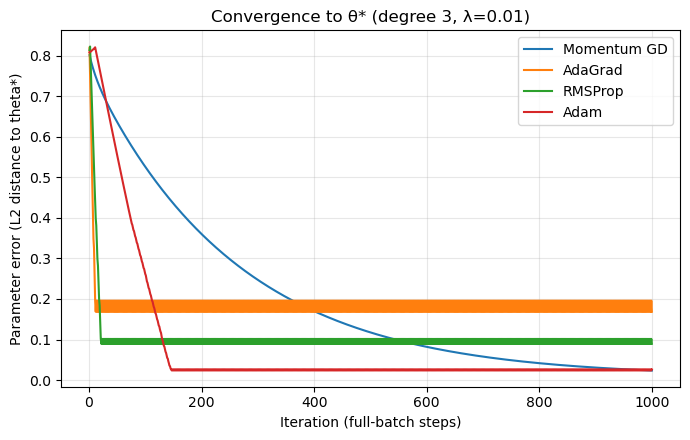

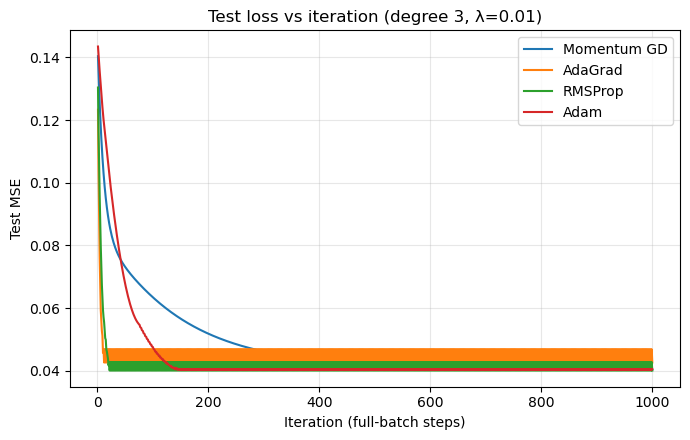

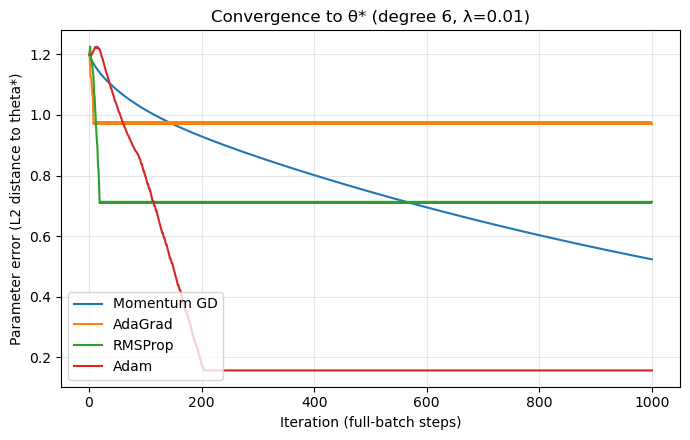

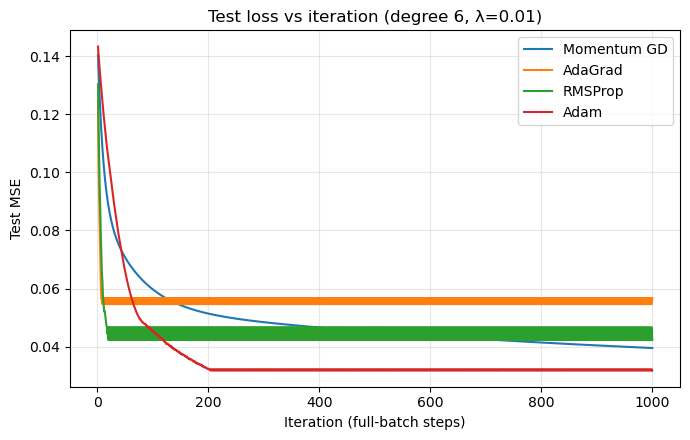

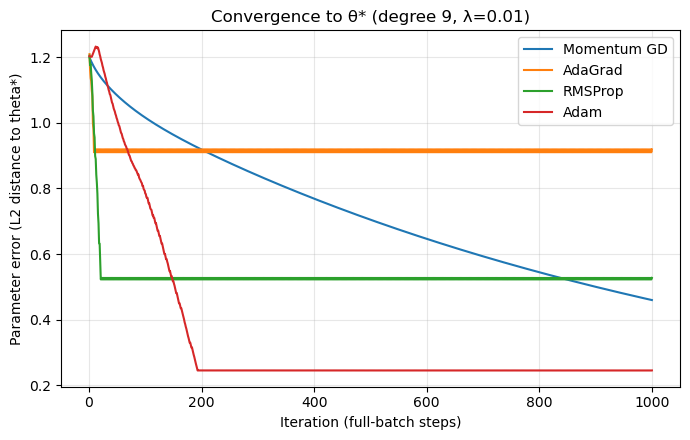

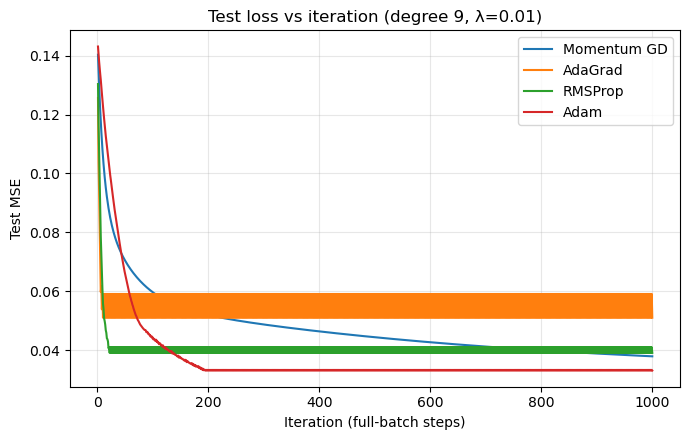

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# --- where to save ---
OUTDIR = "figures"
os.makedirs(OUTDIR, exist_ok=True)

# --- closed-form optimum matching your objective (on TRAIN split) ---
def closed_form_optimum(X, y, lam=0.0, regularize_bias=False):
    n, p = X.shape
    A = X.T @ X
    I = np.eye(p)
    if not regularize_bias:
        I[0, 0] = 0.0
    return np.linalg.solve(A + (n * lam) * I, X.T @ y)

# --- run any of your optimizers step-by-step (no edits needed) ---
def run_with_tracking(optimizer_fn, X, y, T=1000, theta0=None, **kwargs):
    n, p = X.shape
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    thetas, losses, grad_norms = [], [], []
    for _ in range(T):
        theta, hist = optimizer_fn(
            X, y,
            max_iters=1,
            grad_tol=0.0,
            theta0=theta,
            **kwargs
        )
        thetas.append(theta.copy())
        losses.append(hist["loss"][-1] if hist["loss"] else np.nan)
        grad_norms.append(hist["grad_norm"][-1] if hist["grad_norm"] else np.nan)
    return {
        "theta_path": np.array(thetas),
        "loss": np.array(losses),
        "grad_norm": np.array(grad_norms),
        "theta_final": theta,
    }

# ------------------ experiment config ------------------
degrees = [3, 6, 9]
lam = 0.01                 # OLS; try 1e-3..1e-2 for ridge-stabilized runs
regularize_bias = False
T = 1000                  # iterations (for full-batch, one step ~= one epoch)

# learning rates (tweak if needed)
gd_cfg     = dict(eta=2e-2,  mu=0.9,  lam=lam, regularize_bias=regularize_bias)
adagrad_cfg= dict(eta=5e-2,  delta=1e-8, lam=lam, regularize_bias=regularize_bias)
rmsprop_cfg= dict(eta=1e-2,  rho=0.9,  delta=1e-8, lam=lam, regularize_bias=regularize_bias)
adam_cfg   = dict(eta=5e-3,  beta1=0.9, beta2=0.999, delta=1e-8, lam=lam, regularize_bias=regularize_bias)

# ------------------ train/test split ONCE and run ------------------
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=42)

results = {}

for d in degrees:
    Xtr = design_matrix(x_tr, d)
    Xte = design_matrix(x_te, d)

    theta_star = closed_form_optimum(Xtr, y_tr, lam=lam, regularize_bias=regularize_bias)

    gd_res   = run_with_tracking(gd_momentum_batch, Xtr, y_tr, T=T, **gd_cfg)
    ada_res  = run_with_tracking(adagrad_batch,      Xtr, y_tr, T=T, **adagrad_cfg)
    rms_res  = run_with_tracking(rmsprop_batch,      Xtr, y_tr, T=T, **rmsprop_cfg)
    adam_res = run_with_tracking(adam_batch,         Xtr, y_tr, T=T, **adam_cfg)

    def param_err(res):
        th_path = res["theta_path"]
        return np.linalg.norm(th_path - theta_star[None, :], axis=1)

    def test_mse_path(res):
        th_path = res["theta_path"]
        errs = []
        for th in th_path:
            r = y_te - Xte @ th
            errs.append((r @ r) / len(y_te))   # pure test MSE
        return np.array(errs)

    results[d] = {
        "theta_star": theta_star,
        "gd":   {"perr": param_err(gd_res),   "test_mse": test_mse_path(gd_res)},
        "ada":  {"perr": param_err(ada_res),  "test_mse": test_mse_path(ada_res)},
        "rms":  {"perr": param_err(rms_res),  "test_mse": test_mse_path(rms_res)},
        "adam": {"perr": param_err(adam_res), "test_mse": test_mse_path(adam_res)},
    }

    it = np.arange(1, len(results[d]["gd"]["perr"]) + 1)

    # ---- parameter error vs iteration ----
    plt.figure(figsize=(7,4.5))
    for key, label in [("gd","Momentum GD"), ("ada","AdaGrad"), ("rms","RMSProp"), ("adam","Adam")]:
        plt.plot(it, results[d][key]["perr"], label=label)
    plt.xlabel("Iteration (full-batch steps)")
    plt.ylabel("Parameter error (L2 distance to theta*)")
    plt.title(f"Convergence to θ* (degree {d}, λ={lam})")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.savefig(f"{OUTDIR}/param_error_deg{d}.png", dpi=200, bbox_inches="tight")
    plt.tight_layout(); plt.show()

    # ---- TEST loss (MSE) vs iteration ----
    plt.figure(figsize=(7,4.5))
    for key, label in [("gd","Momentum GD"), ("ada","AdaGrad"), ("rms","RMSProp"), ("adam","Adam")]:
        plt.plot(it, results[d][key]["test_mse"], label=label)
    plt.xlabel("Iteration (full-batch steps)")
    plt.ylabel("Test MSE")
    plt.title(f"Test loss vs iteration (degree {d}, λ={lam})")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.savefig(f"{OUTDIR}/test_mse_deg{d}.png", dpi=200, bbox_inches="tight")
    plt.tight_layout(); plt.show()


From the figure, with Ridge Regression, we observe the same results but ADAM converges to the optimal paramaters at higher degrees as well.

### Part e: Lasso Regression

In [14]:
def soft_threshold(z, t):
    # element-wise soft-threshold
    return np.sign(z) * np.maximum(np.abs(z) - t, 0.0)

def standardize_design_matrix_cols_1p(X):
    """Standardize columns 1..p-1 (leave intercept) for L1 stability."""
    Xs = X.copy()
    if Xs.shape[1] > 1:
        mu = Xs[:, 1:].mean(axis=0)
        sd = Xs[:, 1:].std(axis=0) + 1e-12
        Xs[:, 1:] = (Xs[:, 1:] - mu) / sd
    return Xs

def lasso_ista(
    X, y, lam, max_iters=10000, tol=1e-8, theta0=None, standardize_cols=True
):
    """
    Solve:  C(θ) = (1/n)||y - Xθ||^2 + λ||θ||_1  (no penalty on θ0)
    ISTA update:
        θ^{k+1} = S_{λt} ( θ^k - t * ∇(1/n)||y - Xθ||^2 )
    where ∇ = (2/n) X^T (Xθ - y),  t = 1/L,  L = (2/n) λ_max(X^T X).
    """
    n, p = X.shape
    # optional standardization of columns 1..p-1 (recommended for L1)
    Xs = standardize_design_matrix_cols_1p(X) if standardize_cols else X
    theta = np.zeros(p) if theta0 is None else theta0.copy()

    # Lipschitz constant of the smooth part
    L = (2.0 / n) * np.linalg.eigvalsh(Xs.T @ Xs).max()
    t = 1.0 / (L + 1e-18)

    history = {"obj": []}

    def obj(theta):
        r = y - Xs @ theta
        return (r @ r) / n + lam * np.sum(np.abs(theta[1:]))

    # iterate
    prev = obj(theta)
    history["obj"].append(prev)

    for _ in range(max_iters):
        # gradient of (1/n)||y - Xθ||^2
        g = (2.0 / n) * (Xs.T @ (Xs @ theta - y))
        # gradient step
        z = theta - t * g
        # soft-threshold on j>=1 (exclude intercept θ0)
        z0 = z[0]
        z_rest = soft_threshold(z[1:], lam * t)
        theta_new = np.empty_like(theta)
        theta_new[0] = z0
        theta_new[1:] = z_rest

        cur = obj(theta_new)
        history["obj"].append(cur)

        if abs(prev - cur) < tol:
            theta = theta_new
            break
        theta, prev = theta_new, cur

    return theta, history, Xs 


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-06, tolerance: 1.309e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.334e-06, tolerance: 1.309e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

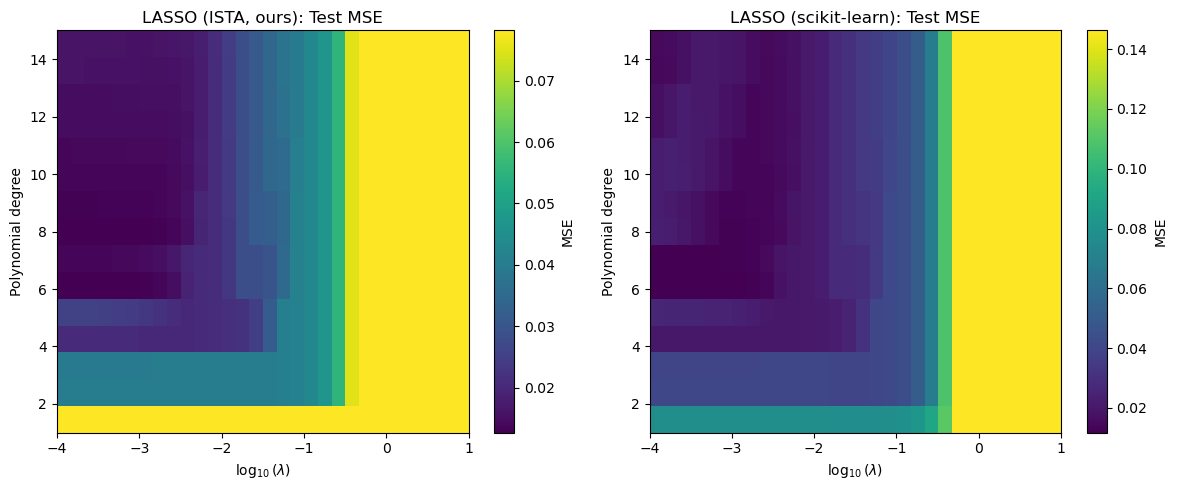

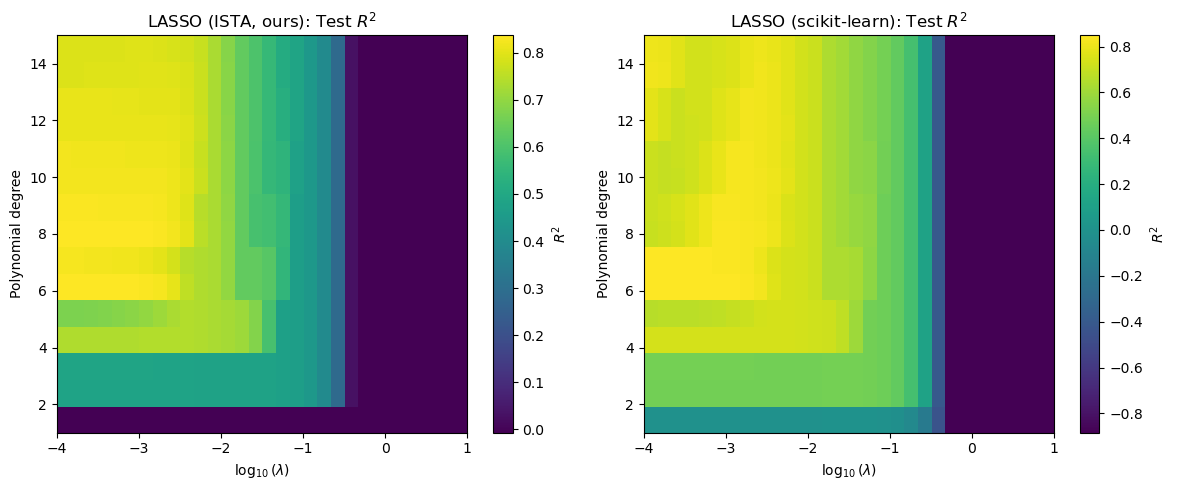

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

def standardize_train_test(Xtr, Xte):
    Xtr_ = Xtr.copy()
    Xte_ = Xte.copy()
    if Xtr_.shape[1] > 1:
        mu = Xtr_[:, 1:].mean(axis=0)
        sd = Xtr_[:, 1:].std(axis=0) + 1e-12
        Xtr_[:, 1:] = (Xtr_[:, 1:] - mu) / sd
        Xte_[:, 1:] = (Xte_[:, 1:] - mu) / sd
    return Xtr_, Xte_

def lasso_heatmap_metrics(degrees, lambdas):
    M_mse_ista = np.zeros((len(degrees), len(lambdas)))
    M_mse_skl  = np.zeros((len(degrees), len(lambdas)))
    M_r2_ista  = np.zeros((len(degrees), len(lambdas)))
    M_r2_skl   = np.zeros((len(degrees), len(lambdas)))

    for i, d in enumerate(degrees):
        # build raw design matrices then standardize (same transform for ISTA & sklearn)
        Xtr = design_matrix(x_train_scaled, d)
        Xte = design_matrix(x_test_scaled,  d)
        Xtr_s, Xte_s = standardize_train_test(Xtr, Xte)

        for j, lam in enumerate(lambdas):
            # --- our ISTA (uses the standardized X) ---
            theta, _, _ = lasso_ista(Xtr_s, y_train, lam=lam, max_iters=4000, tol=1e-8, standardize_cols=False)
            yhat_te = Xte_s @ theta
            M_mse_ista[i, j] = mse(y_test, yhat_te)
            M_r2_ista[i, j]  = r2_value(y_test, yhat_te)

            # --- scikit-learn (same scaling, no intercept) ---
            alpha = lam / 2.0  # match objectives
            clf = Lasso(alpha=alpha, fit_intercept=False, max_iter=100000, tol=1e-8)
            clf.fit(Xtr_s, y_train)
            yhat_te_skl = clf.predict(Xte_s)
            M_mse_skl[i, j] = mse(y_test, yhat_te_skl)
            M_r2_skl[i, j]  = r2_value(y_test, yhat_te_skl)

    return {
        "ista": {"mse": M_mse_ista, "r2": M_r2_ista},
        "skl":  {"mse": M_mse_skl,  "r2": M_r2_skl},
    }

# --- choose grids ---
degrees = np.arange(1, 16)                    # 1..15
lambdas = np.logspace(-4, 1, 30)              # 10^{-4} ... 10^{1}
resHM = lasso_heatmap_metrics(degrees, lambdas)
loglam = np.log10(lambdas)

# --- plotting utility ---
def plot_heatmap(matrix, title, degrees, loglam, cbar_label, vmax=None):
    plt.imshow(
        matrix, aspect='auto', origin='lower', cmap='viridis',
        extent=[loglam.min(), loglam.max(), degrees.min(), degrees.max()],
        vmin=None, vmax=vmax
    )
    plt.colorbar(label=cbar_label)
    plt.xlabel(r'$\log_{10}(\lambda)$')
    plt.ylabel('Polynomial degree')
    plt.title(title)

# --- Figure 1: MSE heatmaps (ISTA vs scikit) ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_heatmap(resHM["ista"]["mse"], "LASSO (ISTA, ours): Test MSE", degrees, loglam, "MSE")
plt.subplot(1,2,2)
plot_heatmap(resHM["skl"]["mse"],  "LASSO (scikit-learn): Test MSE", degrees, loglam, "MSE")
plt.tight_layout()
plt.show()

# --- Figure 2: R² heatmaps (ISTA vs scikit) ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_heatmap(resHM["ista"]["r2"], "LASSO (ISTA, ours): Test $R^2$", degrees, loglam, r"$R^2$")
plt.subplot(1,2,2)
plot_heatmap(resHM["skl"]["r2"],  "LASSO (scikit-learn): Test $R^2$", degrees, loglam, r"$R^2$")
plt.tight_layout()
plt.show()

Caption:

Figure Lasso: Test MSE (left) and R^2 (right) vs log10($\lambda$) for LASSO with polynomial degree 10. Results from our proximal gradient (ISTA) solver align closely with scikit-learn’s Lasso. Both methods achieve low error for small $\lambda$, but as regularization strengthens, coefficients are driven to zero, leading to increasing test MSE and decreasing R^2.

Part (e): LASSO via Proximal Gradient and Comparison with scikit-learn
We implemented LASSO using proximal gradient descent (ISTA) with soft-thresholding and compared the results against scikit-learn’s Lasso. Figure Lasso shows the test MSE and R^2 as a function of $\lambda$ for polynomial degree 10. Both implementations display the same qualitative behavior: for small $\lambda$, LASSO recovers a near-OLS solution with low bias but higher variance, resulting in strong predictive accuracy. As $\lambda$ increases, both methods gradually shrink coefficients, leading to higher bias but lower variance. At very large $\lambda$, the models collapse towards zero coefficients, causing MSE to rise and R^2 to drop sharply below zero. Our ISTA implementation tracks scikit-learn’s results closely, with small deviations at larger $\lambda$ due to differences in stopping tolerance and scaling conventions. Overall, the comparison validates the correctness of our proximal gradient approach while highlighting LASSO’s key property of driving coefficients exactly to zero, in contrast to Ridge from Part (b) which only shrinks them.

### Part f: Stochastic Gradient Descent

We first define functions for Stochastic Gradient Descent. We will be working with 2 main methods of Stochastic Gradient Descent, which are Minibatch Gradient Descent, with and without placement. We will also ADAM for the learning rate.

In [16]:
import numpy as np

def adam_ols_minibatch_v1(
    X, y,
    alpha=1e-2,           # Adam step size
    beta1=0.9, beta2=0.999, eps=1e-8,
    batch_size=32,
    epochs=50,
    steps_per_epoch=None,  
    grad_tol=1e-8,
    theta0=None,
    weight_decay=0.0,     
    seed=None
):
    n, p = X.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    t = 0

    if steps_per_epoch is None:
        steps_per_epoch = max(1, n // max(1, batch_size))

    history = {"loss": [], "grad_norm": []}

    for _ in range(epochs):
        for _ in range(steps_per_epoch):
            idx = rng.choice(n, size=batch_size, replace=True)  # with replacement
            Xb, yb = X[idx], y[idx]

            rb   = Xb @ theta - yb
            grad = (2.0 / batch_size) * (Xb.T @ rb)

            if weight_decay:
                theta *= (1 - alpha * weight_decay)

            t += 1
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            mhat = m / (1 - beta1**t)
            vhat = v / (1 - beta2**t)
            theta -= alpha * mhat / (np.sqrt(vhat) + eps)

        r_full = X @ theta - y
        loss_full = (r_full @ r_full) / n
        grad_full = (2.0 / n) * (X.T @ r_full)
        history["loss"].append(loss_full)
        history["grad_norm"].append(np.linalg.norm(grad_full))
        if np.linalg.norm(grad_full) <= grad_tol:
            break

    return theta, history


In [17]:
import numpy as np
import math

def adam_ols_minibatch_v2(
    X, y,
    alpha=1e-2,           
    beta1=0.9, beta2=0.999, eps=1e-8,
    batch_size=32,
    epochs=50,
    grad_tol=1e-8,
    theta0=None,
    weight_decay=0.0,    
    seed=None
):
    n, p = X.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    t = 0

    history = {"loss": [], "grad_norm": []}
    steps_per_epoch = math.ceil(n / max(1, batch_size))

    for _ in range(epochs):
        perm = rng.permutation(n) #shuffle once per epoch

        for s in range(steps_per_epoch):
            start = s * batch_size
            end   = min((s + 1) * batch_size, n)
            idx   = perm[start:end]

            Xb, yb = X[idx], y[idx]
            rb   = Xb @ theta - yb
            grad = (2.0 / len(idx)) * (Xb.T @ rb)

            if weight_decay:
                theta *= (1 - alpha * weight_decay)

            t += 1
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            mhat = m / (1 - beta1**t)
            vhat = v / (1 - beta2**t)
            theta -= alpha * mhat / (np.sqrt(vhat) + eps)

        r_full = X @ theta - y
        loss_full = (r_full @ r_full) / n
        grad_full = (2.0 / n) * (X.T @ r_full)
        gnorm = np.linalg.norm(grad_full)
        history["loss"].append(loss_full)
        history["grad_norm"].append(gnorm)
        if gnorm <= grad_tol:
            break

    return theta, history


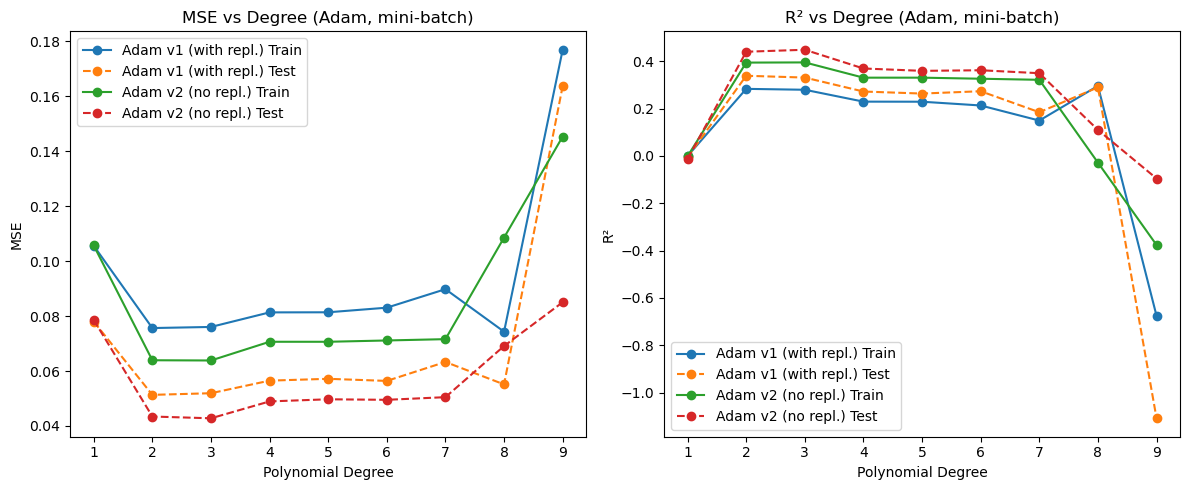

In [18]:
import numpy as np
import matplotlib.pyplot as plt

degrees     = range(1, 10)
grad_tol    = 1e-8
alpha_adam  = 1e-2      
batch_size  = 32
epochs      = 20

methods = {
    "Adam v1 (with repl.)": lambda X, y, theta0: adam_ols_minibatch_v1(
        X, y,
        alpha=alpha_adam,
        beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=None,  
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=0.0,    
        seed=0
    ),
    "Adam v2 (no repl.)": lambda X, y, theta0: adam_ols_minibatch_v2(
        X, y,
        alpha=alpha_adam,
        beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=batch_size,
        epochs=epochs,
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=0.0,
        seed=0
    ),
}

results = {name: {"mse_train": [], "mse_test": [], "r2_train": [], "r2_test": []}
           for name in methods}

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test  = design_matrix(x_test_scaled,  d)
    theta0  = np.zeros(X_train.shape[1])  

    for name, fit in methods.items():
        beta, _ = fit(X_train, y_train, theta0)
        ytr_hat = predict(X_train, beta)
        yte_hat = predict(X_test,  beta)

        results[name]["mse_train"].append(mse(y_train, ytr_hat))
        results[name]["mse_test"].append(mse(y_test,  yte_hat))
        results[name]["r2_train"].append(r2_value(y_train, ytr_hat))
        results[name]["r2_test"].append(r2_value(y_test,  yte_hat))

# ---- Plots ----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for name in methods:
    plt.plot(degrees, results[name]["mse_train"], 'o-', label=f'{name} Train')
    plt.plot(degrees, results[name]["mse_test"],  'o--', label=f'{name} Test')
plt.xlabel("Polynomial Degree"); plt.ylabel("MSE")
plt.title("MSE vs Degree (Adam, mini-batch)")
plt.legend()

plt.subplot(1,2,2)
for name in methods:
    plt.plot(degrees, results[name]["r2_train"], 'o-', label=f'{name} Train')
    plt.plot(degrees, results[name]["r2_test"],  'o--', label=f'{name} Test')
plt.xlabel("Polynomial Degree"); plt.ylabel("R²")
plt.title("R² vs Degree (Adam, mini-batch)")
plt.legend(); plt.tight_layout(); plt.show()


The figure above shows the results for Stochastic Gradient Descent with ADAM and number of epochs = 20, iterating over the number of Polynomial Degrees. The results are rather similar to plain gradient descent, where at high degrees the test error increases significantly. Furthermore, SGD V2 seems to perform better than V1. This is because in V1 we sample batches with replacement and the same data can be seen multiple times in an epoch while others are skipped. As a result, the mini-batch gradients of V2 have lower variance, and the coverage is balanced, leading to better convergence


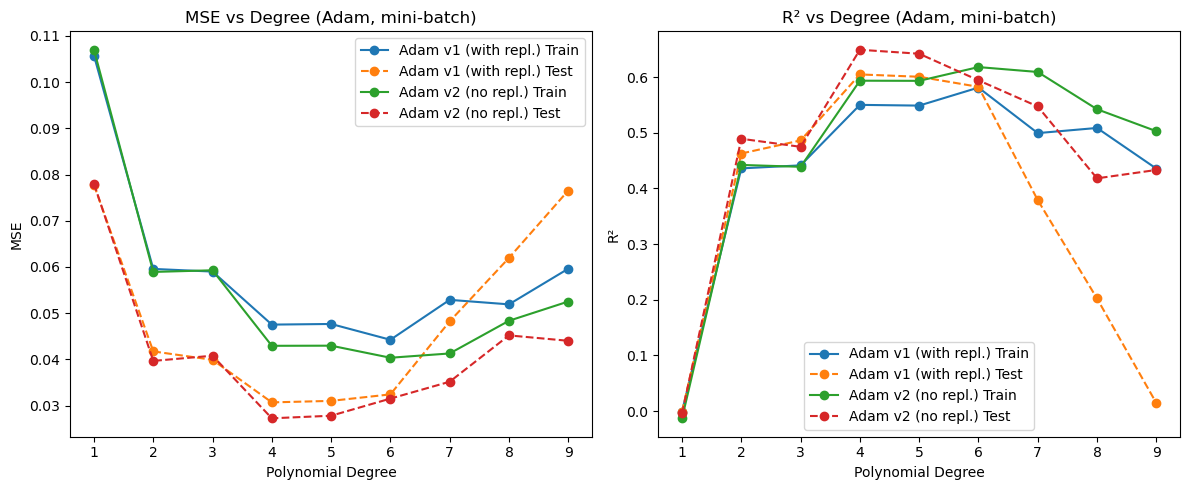

In [19]:
import numpy as np
import matplotlib.pyplot as plt

degrees     = range(1, 10)
grad_tol    = 1e-8
alpha_adam  = 1e-2     
batch_size  = 32
epochs      = 50   

methods = {
    "Adam v1 (with repl.)": lambda X, y, theta0: adam_ols_minibatch_v1(
        X, y,
        alpha=alpha_adam,
        beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=None,        
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=0.0,           
        seed=0
    ),
    "Adam v2 (no repl.)": lambda X, y, theta0: adam_ols_minibatch_v2(
        X, y,
        alpha=alpha_adam,
        beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=batch_size,
        epochs=epochs,
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=0.0,
        seed=0
    ),
}

results = {name: {"mse_train": [], "mse_test": [], "r2_train": [], "r2_test": []}
           for name in methods}

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test  = design_matrix(x_test_scaled,  d)
    theta0  = np.zeros(X_train.shape[1])   # same init for fairness

    for name, fit in methods.items():
        beta, _ = fit(X_train, y_train, theta0)
        ytr_hat = predict(X_train, beta)
        yte_hat = predict(X_test,  beta)

        results[name]["mse_train"].append(mse(y_train, ytr_hat))
        results[name]["mse_test"].append(mse(y_test,  yte_hat))
        results[name]["r2_train"].append(r2_value(y_train, ytr_hat))
        results[name]["r2_test"].append(r2_value(y_test,  yte_hat))

# ---- Plots ----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for name in methods:
    plt.plot(degrees, results[name]["mse_train"], 'o-', label=f'{name} Train')
    plt.plot(degrees, results[name]["mse_test"],  'o--', label=f'{name} Test')
plt.xlabel("Polynomial Degree"); plt.ylabel("MSE"); plt.title("MSE vs Degree (Adam, mini-batch)")
plt.legend()

plt.subplot(1,2,2)
for name in methods:
    plt.plot(degrees, results[name]["r2_train"], 'o-', label=f'{name} Train')
    plt.plot(degrees, results[name]["r2_test"],  'o--', label=f'{name} Test')
plt.xlabel("Polynomial Degree"); plt.ylabel("R²"); plt.title("R² vs Degree (Adam, mini-batch)")
plt.legend(); plt.tight_layout(); plt.show()


The figure above shows the same Gradient descent but with a larger number of epochs. With a higher number of epochs, there is more parameter updates and we are closer to the ols minimizer, and we can see that the difference in test MSE is much lesser between SGD V1 and V2

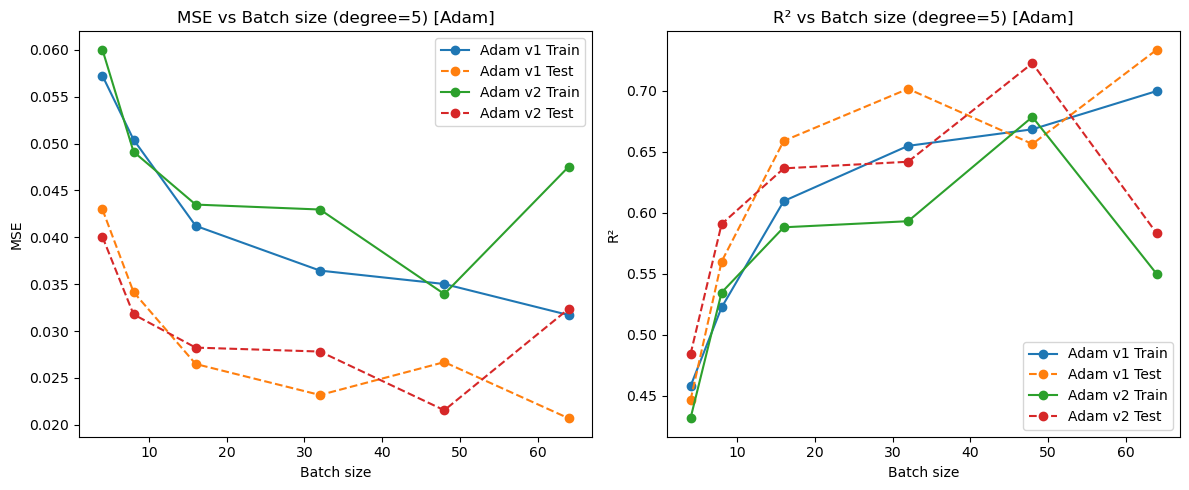

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- Settings ---
degree      = 5
grad_tol    = 1e-8
alpha_adam  = 1e-2        
weight_decay = 0.0       
epochs_ref  = 50          
b_ref       = 32          
candidate_batch_sizes = [4, 8, 16, 32, 48, 64, 96, 128, 256]

# --- Build design matrices once ---
X_train = design_matrix(x_train_scaled, degree)
X_test  = design_matrix(x_test_scaled,  degree)
n = X_train.shape[0]
batch_sizes = [b for b in candidate_batch_sizes if 1 <= b <= n]

# reference total updates
U_ref = epochs_ref * math.ceil(n / b_ref)

mse_train_v1, mse_test_v1, r2_train_v1, r2_test_v1 = [], [], [], []
mse_train_v2, mse_test_v2, r2_train_v2, r2_test_v2 = [], [], [], []

for bsz in batch_sizes:
    theta0 = np.zeros(X_train.shape[1])

    steps_per_epoch = math.ceil(n / bsz)
    epochs_b = max(1, math.ceil(U_ref / steps_per_epoch))


    alpha_b = alpha_adam

    beta_v1, _ = adam_ols_minibatch_v1(
        X_train, y_train,
        alpha=alpha_b, beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=bsz,
        epochs=epochs_b,
        steps_per_epoch=steps_per_epoch,  # make v1 comparable to v2
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=weight_decay,
        seed=0
    )
    ytr = predict(X_train, beta_v1); yte = predict(X_test, beta_v1)
    mse_train_v1.append(mse(y_train, ytr)); mse_test_v1.append(mse(y_test, yte))
    r2_train_v1.append(r2_value(y_train, ytr)); r2_test_v1.append(r2_value(y_test, yte))

    beta_v2, _ = adam_ols_minibatch_v2(
        X_train, y_train,
        alpha=alpha_b, beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=bsz,
        epochs=epochs_b,
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=weight_decay,
        seed=0
    )
    ytr = predict(X_train, beta_v2); yte = predict(X_test, beta_v2)
    mse_train_v2.append(mse(y_train, ytr)); mse_test_v2.append(mse(y_test, yte))
    r2_train_v2.append(r2_value(y_train, ytr)); r2_test_v2.append(r2_value(y_test, yte))

# --- Plots ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(batch_sizes, mse_train_v1, 'o-', label='Adam v1 Train')
plt.plot(batch_sizes, mse_test_v1,  'o--', label='Adam v1 Test')
plt.plot(batch_sizes, mse_train_v2, 'o-', label='Adam v2 Train')
plt.plot(batch_sizes, mse_test_v2,  'o--', label='Adam v2 Test')
plt.xlabel("Batch size"); plt.ylabel("MSE"); plt.title(f"MSE vs Batch size (degree={degree}) [Adam]")
plt.legend()

plt.subplot(1,2,2)
plt.plot(batch_sizes, r2_train_v1, 'o-', label='Adam v1 Train')
plt.plot(batch_sizes, r2_test_v1,  'o--', label='Adam v1 Test')
plt.plot(batch_sizes, r2_train_v2, 'o-', label='Adam v2 Train')
plt.plot(batch_sizes, r2_test_v2,  'o--', label='Adam v2 Test')
plt.xlabel("Batch size"); plt.ylabel("R²"); plt.title(f"R² vs Batch size (degree={degree}) [Adam]")
plt.legend(); plt.tight_layout(); plt.show()


The figure above shows the results for Stochastic Gradient Descent with a fixed learning rate, iterating over Batch Size with a fixed polynomial degree. We do not fix the number of epochs since for larger batch sizes, the parameters is updated less for a fixed number of epochs. So we increase the number of epochs as the batch size increases. The test MSE improves as the number of batch size increases initially, before it worsens. This is because at small batch sizes, there is too much noise under training. While at larger batch sizes, we lose the stochastic regularization.

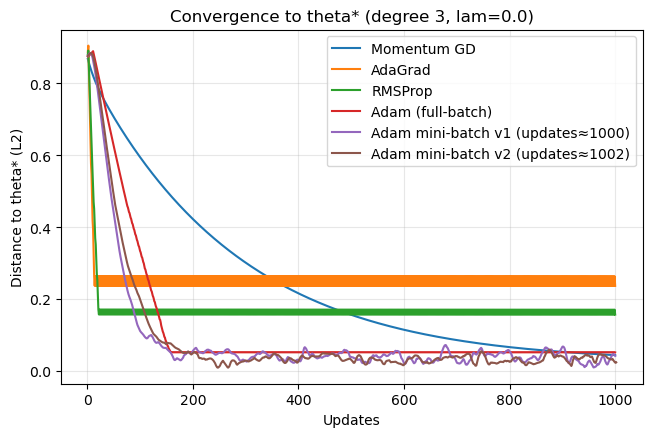

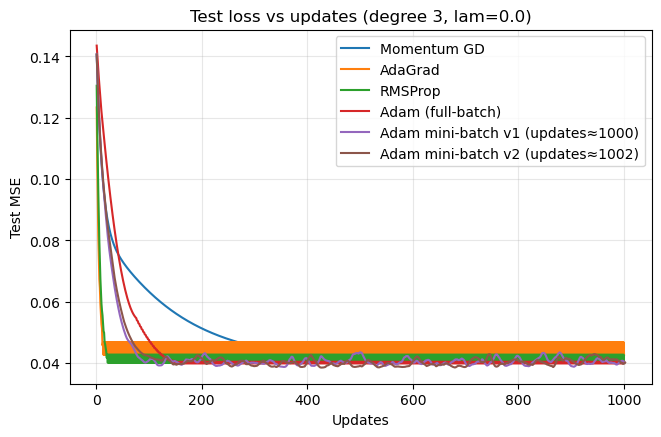

[degree 3] target_updates=1000, v1: steps/epoch=2, epochs=500, total≈1000; v2: steps/epoch=3, epochs=334, total≈1002
Saved: figs_convergence_with_minibatch/convergence_to_theta_star_degree3.png
Saved: figs_convergence_with_minibatch/test_loss_degree3.png


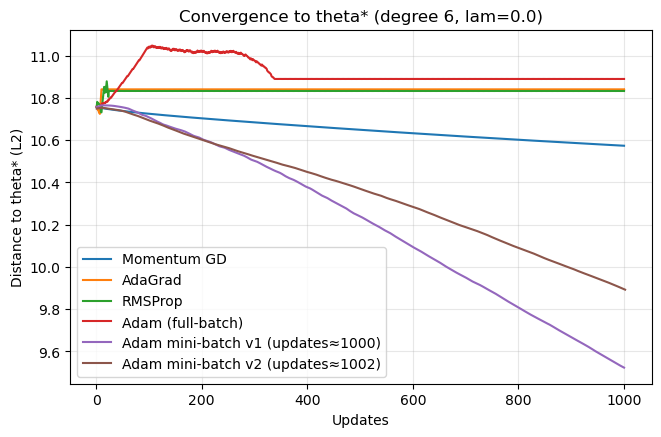

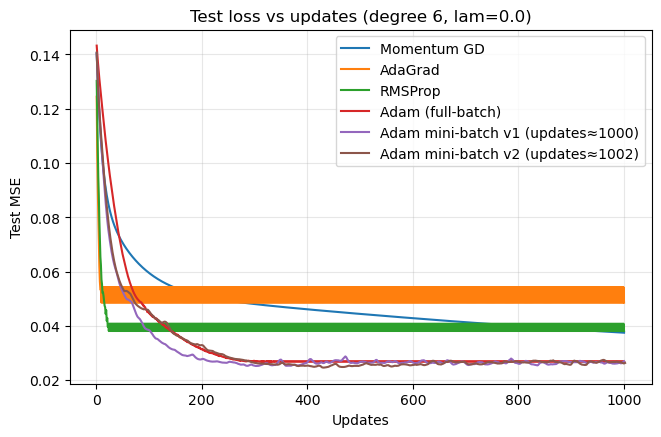

[degree 6] target_updates=1000, v1: steps/epoch=2, epochs=500, total≈1000; v2: steps/epoch=3, epochs=334, total≈1002
Saved: figs_convergence_with_minibatch/convergence_to_theta_star_degree6.png
Saved: figs_convergence_with_minibatch/test_loss_degree6.png


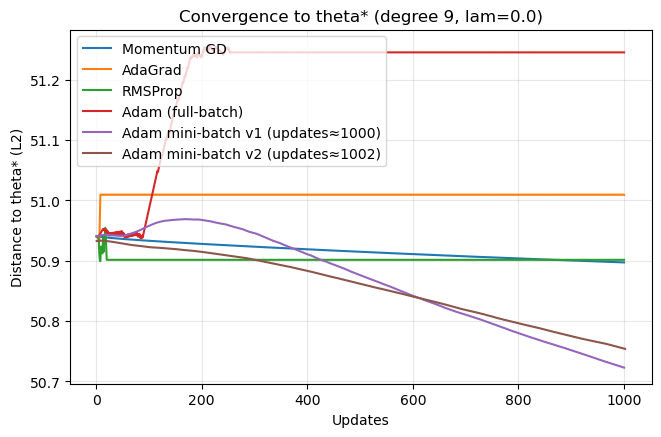

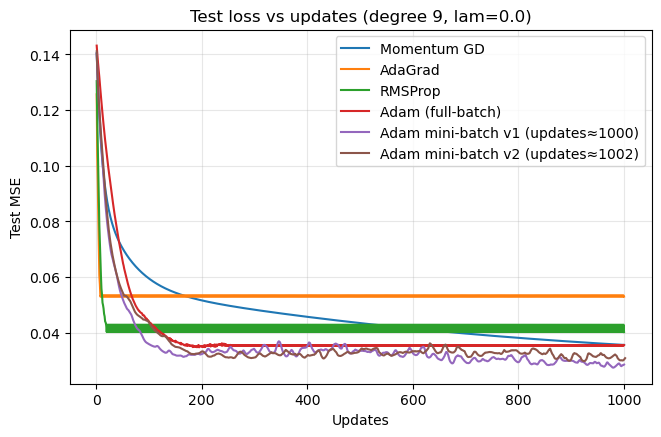

[degree 9] target_updates=1000, v1: steps/epoch=2, epochs=500, total≈1000; v2: steps/epoch=3, epochs=334, total≈1002
Saved: figs_convergence_with_minibatch/convergence_to_theta_star_degree9.png
Saved: figs_convergence_with_minibatch/test_loss_degree9.png


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os, math

# ---------- helpers ----------
def closed_form_optimum(X, y, lam=0.0, regularize_bias=False):
    """θ* for (1/n)||y - Xθ||^2 + lam||θ||^2 (no penalty on intercept if regularize_bias=False)."""
    n, p = X.shape
    A = X.T @ X
    I = np.eye(p)
    if not regularize_bias:
        I[0, 0] = 0.0
    return np.linalg.solve(A + (n * lam) * I, X.T @ y)

def test_mse(Xte, yte, theta):
    r = yte - Xte @ theta
    return (r @ r) / len(yte)


def run_fullbatch_with_tracking(optimizer_fn, Xtr, ytr, Xte, yte, T=1000, **kwargs):
    n, p = Xtr.shape
    theta = np.zeros(p) if kwargs.get("theta0") is None else kwargs["theta0"].copy()
    thetas, tloss = [], []
    for _ in range(T):
        theta, hist = optimizer_fn(
            Xtr, ytr, max_iters=1, grad_tol=0.0, theta0=theta,
            **{k:v for k,v in kwargs.items() if k!="theta0"}
        )
        thetas.append(theta.copy())
        tloss.append(test_mse(Xte, yte, theta))
    return np.array(thetas), np.array(tloss)


def run_minibatch_adam_v1_tracking(Xtr, ytr, Xte, yte,
                                   alpha=1e-2, beta1=0.9, beta2=0.999, eps=1e-8,
                                   batch_size=32, epochs=50, steps_per_epoch=None,
                                   weight_decay=0.0, seed=0, theta0=None):
    n, p = Xtr.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    m = np.zeros_like(theta); v = np.zeros_like(theta); t = 0

    if steps_per_epoch is None:
        steps_per_epoch = max(1, n // max(1, batch_size))  # floor

    thetas, tloss = [], []
    for _ in range(epochs):
        for _ in range(steps_per_epoch):
            idx = rng.choice(n, size=batch_size, replace=True)
            Xb, yb = Xtr[idx], ytr[idx]
            rb   = Xb @ theta - yb
            grad = (2.0 / batch_size) * (Xb.T @ rb)

            if weight_decay:
                theta *= (1 - alpha * weight_decay)

            t += 1
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            mhat = m / (1 - beta1**t)
            vhat = v / (1 - beta2**t)
            theta -= alpha * mhat / (np.sqrt(vhat) + eps)

            thetas.append(theta.copy())
            tloss.append(test_mse(Xte, yte, theta))
    return np.array(thetas), np.array(tloss)


def run_minibatch_adam_v2_tracking(Xtr, ytr, Xte, yte,
                                   alpha=1e-2, beta1=0.9, beta2=0.999, eps=1e-8,
                                   batch_size=32, epochs=50,
                                   weight_decay=0.0, seed=0, theta0=None):
    n, p = Xtr.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    m = np.zeros_like(theta); v = np.zeros_like(theta); t = 0

    steps_per_epoch = math.ceil(n / max(1, batch_size))    # ceil

    thetas, tloss = [], []
    for _ in range(epochs):
        perm = rng.permutation(n)
        for s in range(steps_per_epoch):
            start = s * batch_size
            end   = min((s + 1) * batch_size, n)
            idx   = perm[start:end]
            Xb, yb = Xtr[idx], ytr[idx]
            rb   = Xb @ theta - yb
            grad = (2.0 / len(idx)) * (Xb.T @ rb)

            if weight_decay:
                theta *= (1 - alpha * weight_decay)

            t += 1
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            mhat = m / (1 - beta1**t)
            vhat = v / (1 - beta2**t)
            theta -= alpha * mhat / (np.sqrt(vhat) + eps)

            thetas.append(theta.copy())
            tloss.append(test_mse(Xte, yte, theta))
    return np.array(thetas), np.array(tloss)


degrees = [3, 6, 9]
lam = 0.0
regularize_bias = False


T_full = 1000   
gd_cfg      = dict(eta=2e-2,  mu=0.9,   lam=lam, regularize_bias=regularize_bias)
adagrad_cfg = dict(eta=5e-2,  delta=1e-8, lam=lam, regularize_bias=regularize_bias)
rmsprop_cfg = dict(eta=1e-2,  rho=0.9, delta=1e-8, lam=lam, regularize_bias=regularize_bias)
adam_cfg    = dict(eta=5e-3,  beta1=0.9, beta2=0.999, delta=1e-8, lam=lam, regularize_bias=regularize_bias)


mb_alpha = 1e-2
mb_batch = 32
mb_seed  = 0

save_dir = "figs_convergence_with_minibatch"
os.makedirs(save_dir, exist_ok=True)

for d in degrees:
    Xtr = design_matrix(x_train, d)
    Xte = design_matrix(x_test,  d)
    ytr, yte = y_train, y_test

    theta_star = closed_form_optimum(Xtr, ytr, lam=lam, regularize_bias=regularize_bias)

   
    th_gd,   tl_gd   = run_fullbatch_with_tracking(gd_momentum_batch, Xtr, ytr, Xte, yte, T=T_full, **gd_cfg)
    th_ada,  tl_ada  = run_fullbatch_with_tracking(adagrad_batch,      Xtr, ytr, Xte, yte, T=T_full, **adagrad_cfg)
    th_rms,  tl_rms  = run_fullbatch_with_tracking(rmsprop_batch,      Xtr, ytr, Xte, yte, T=T_full, **rmsprop_cfg)
    th_adam, tl_adam = run_fullbatch_with_tracking(adam_batch,         Xtr, ytr, Xte, yte, T=T_full, **adam_cfg)

    
    n_train = Xtr.shape[0]
    steps_v1 = max(1, n_train // mb_batch)         
    steps_v2 = math.ceil(n_train / mb_batch)     
    target_updates = T_full                          
    epochs_v1 = math.ceil(target_updates / steps_v1)
    epochs_v2 = math.ceil(target_updates / steps_v2)

    
    th_mb1, tl_mb1 = run_minibatch_adam_v1_tracking(
        Xtr, ytr, Xte, yte,
        alpha=mb_alpha, batch_size=mb_batch,
        epochs=epochs_v1, steps_per_epoch=None,   
        weight_decay=0.0, seed=mb_seed, theta0=None
    )
    th_mb2, tl_mb2 = run_minibatch_adam_v2_tracking(
        Xtr, ytr, Xte, yte,
        alpha=mb_alpha, batch_size=mb_batch,
        epochs=epochs_v2,
        weight_decay=0.0, seed=mb_seed, theta0=None
    )

   
    perr_gd   = np.linalg.norm(th_gd   - theta_star, axis=1)
    perr_ada  = np.linalg.norm(th_ada  - theta_star, axis=1)
    perr_rms  = np.linalg.norm(th_rms  - theta_star, axis=1)
    perr_adam = np.linalg.norm(th_adam - theta_star, axis=1)
    perr_mb1  = np.linalg.norm(th_mb1  - theta_star, axis=1)
    perr_mb2  = np.linalg.norm(th_mb2  - theta_star, axis=1)


    plt.figure(figsize=(7.5, 4.6))
    plt.plot(np.arange(1, len(perr_gd)+1),   perr_gd,   label="Momentum GD")
    plt.plot(np.arange(1, len(perr_ada)+1),  perr_ada,  label="AdaGrad")
    plt.plot(np.arange(1, len(perr_rms)+1),  perr_rms,  label="RMSProp")
    plt.plot(np.arange(1, len(perr_adam)+1), perr_adam, label="Adam (full-batch)")
    plt.plot(np.arange(1, len(perr_mb1)+1),  perr_mb1,  label=f"Adam mini-batch v1 (updates≈{epochs_v1*steps_v1})")
    plt.plot(np.arange(1, len(perr_mb2)+1),  perr_mb2,  label=f"Adam mini-batch v2 (updates≈{epochs_v2*steps_v2})")
    plt.xlabel("Updates"); plt.ylabel("Distance to theta* (L2)")
    plt.title(f"Convergence to theta* (degree {d}, lam={lam})")
    plt.legend(); plt.grid(True, alpha=0.3)
    fpath1 = os.path.join(save_dir, f"convergence_to_theta_star_degree{d}.png")
    plt.savefig(fpath1, dpi=150, bbox_inches="tight"); plt.show()

 
    plt.figure(figsize=(7.5, 4.6))
    plt.plot(np.arange(1, len(tl_gd)+1),   tl_gd,   label="Momentum GD")
    plt.plot(np.arange(1, len(tl_ada)+1),  tl_ada,  label="AdaGrad")
    plt.plot(np.arange(1, len(tl_rms)+1),  tl_rms,  label="RMSProp")
    plt.plot(np.arange(1, len(tl_adam)+1), tl_adam, label="Adam (full-batch)")
    plt.plot(np.arange(1, len(tl_mb1)+1),  tl_mb1,  label=f"Adam mini-batch v1 (updates≈{epochs_v1*steps_v1})")
    plt.plot(np.arange(1, len(tl_mb2)+1),  tl_mb2,  label=f"Adam mini-batch v2 (updates≈{epochs_v2*steps_v2})")
    plt.xlabel("Updates"); plt.ylabel("Test MSE")
    plt.title(f"Test loss vs updates (degree {d}, lam={lam})")
    plt.legend(); plt.grid(True, alpha=0.3)
    fpath2 = os.path.join(save_dir, f"test_loss_degree{d}.png")
    plt.savefig(fpath2, dpi=150, bbox_inches="tight"); plt.show()

    print(f"[degree {d}] target_updates={target_updates}, "
          f"v1: steps/epoch={steps_v1}, epochs={epochs_v1}, total≈{epochs_v1*steps_v1}; "
          f"v2: steps/epoch={steps_v2}, epochs={epochs_v2}, total≈{epochs_v2*steps_v2}")
    print(f"Saved: {fpath1}")
    print(f"Saved: {fpath2}")


From the figure, For both OLS and Ridge, Stochastic Gradient Descent converges the best to the optimal Parameters for the Runge function for all degrees, at the same time having the lowest Test MSE. Minibatch V1 outperforms mini-batch V2 and converges faster.

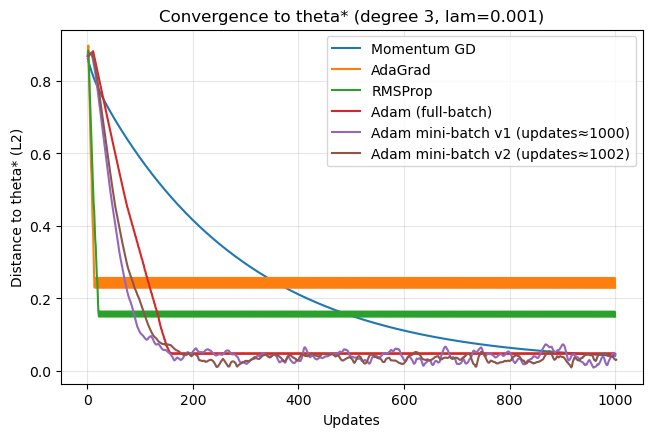

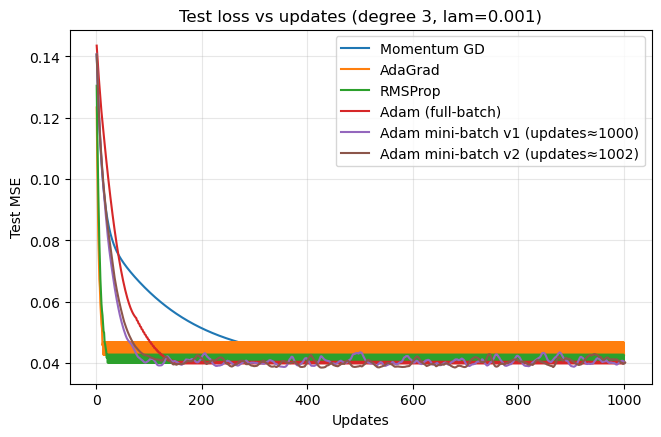

[degree 3] target_updates=1000, v1: steps/epoch=2, epochs=500, total≈1000; v2: steps/epoch=3, epochs=334, total≈1002
Saved: figs_convergence_with_minibatch/convergence_to_theta_star_degree3.png
Saved: figs_convergence_with_minibatch/test_loss_degree3.png


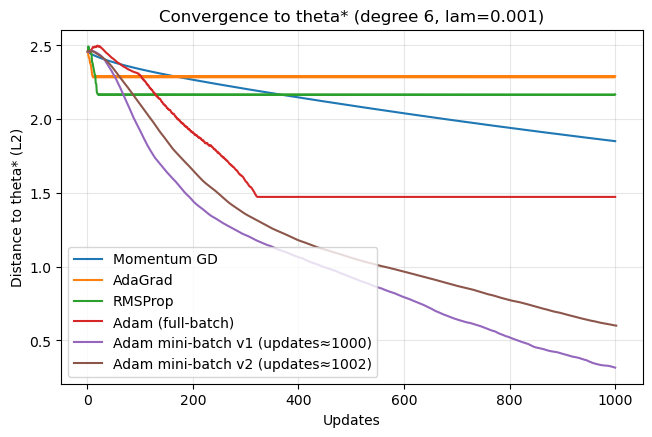

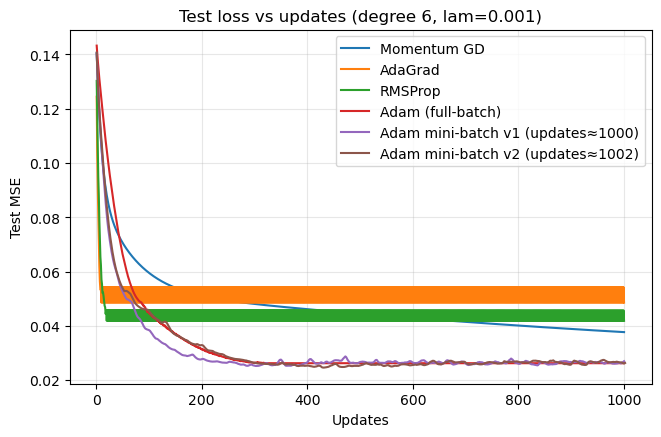

[degree 6] target_updates=1000, v1: steps/epoch=2, epochs=500, total≈1000; v2: steps/epoch=3, epochs=334, total≈1002
Saved: figs_convergence_with_minibatch/convergence_to_theta_star_degree6.png
Saved: figs_convergence_with_minibatch/test_loss_degree6.png


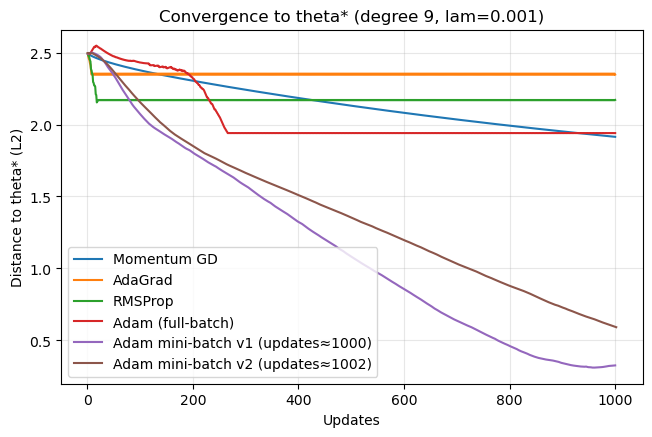

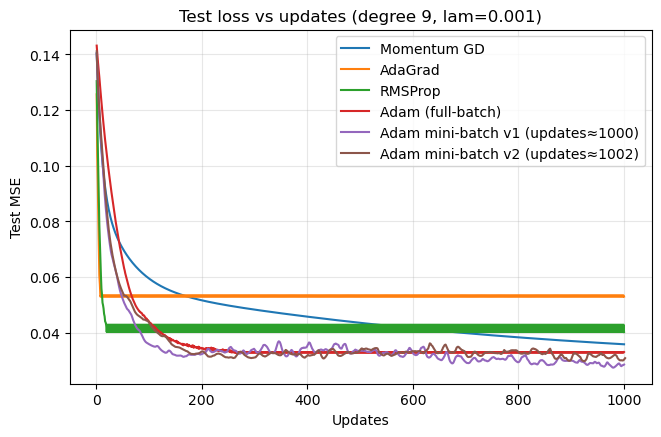

[degree 9] target_updates=1000, v1: steps/epoch=2, epochs=500, total≈1000; v2: steps/epoch=3, epochs=334, total≈1002
Saved: figs_convergence_with_minibatch/convergence_to_theta_star_degree9.png
Saved: figs_convergence_with_minibatch/test_loss_degree9.png


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os, math

def closed_form_optimum(X, y, lam=0.0, regularize_bias=False):
    """θ* for (1/n)||y - Xθ||^2 + lam||θ||^2 (no penalty on intercept if regularize_bias=False)."""
    n, p = X.shape
    A = X.T @ X
    I = np.eye(p)
    if not regularize_bias:
        I[0, 0] = 0.0
    return np.linalg.solve(A + (n * lam) * I, X.T @ y)

def test_mse(Xte, yte, theta):
    r = yte - Xte @ theta
    return (r @ r) / len(yte)


def run_fullbatch_with_tracking(optimizer_fn, Xtr, ytr, Xte, yte, T=1000, **kwargs):
    n, p = Xtr.shape
    theta = np.zeros(p) if kwargs.get("theta0") is None else kwargs["theta0"].copy()
    thetas, tloss = [], []
    for _ in range(T):
        theta, hist = optimizer_fn(
            Xtr, ytr, max_iters=1, grad_tol=0.0, theta0=theta,
            **{k:v for k,v in kwargs.items() if k!="theta0"}
        )
        thetas.append(theta.copy())
        tloss.append(test_mse(Xte, yte, theta))
    return np.array(thetas), np.array(tloss)

def run_minibatch_adam_v1_tracking(Xtr, ytr, Xte, yte,
                                   alpha=1e-2, beta1=0.9, beta2=0.999, eps=1e-8,
                                   batch_size=32, epochs=50, steps_per_epoch=None,
                                   weight_decay=0.0, seed=0, theta0=None):
    n, p = Xtr.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    m = np.zeros_like(theta); v = np.zeros_like(theta); t = 0

    if steps_per_epoch is None:
        steps_per_epoch = max(1, n // max(1, batch_size))  # floor

    thetas, tloss = [], []
    for _ in range(epochs):
        for _ in range(steps_per_epoch):
            idx = rng.choice(n, size=batch_size, replace=True)
            Xb, yb = Xtr[idx], ytr[idx]
            rb   = Xb @ theta - yb
            grad = (2.0 / batch_size) * (Xb.T @ rb)

            if weight_decay:
                theta *= (1 - alpha * weight_decay)

            t += 1
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            mhat = m / (1 - beta1**t)
            vhat = v / (1 - beta2**t)
            theta -= alpha * mhat / (np.sqrt(vhat) + eps)

            thetas.append(theta.copy())
            tloss.append(test_mse(Xte, yte, theta))
    return np.array(thetas), np.array(tloss)


def run_minibatch_adam_v2_tracking(Xtr, ytr, Xte, yte,
                                   alpha=1e-2, beta1=0.9, beta2=0.999, eps=1e-8,
                                   batch_size=32, epochs=50,
                                   weight_decay=0.0, seed=0, theta0=None):
    n, p = Xtr.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    m = np.zeros_like(theta); v = np.zeros_like(theta); t = 0

    steps_per_epoch = math.ceil(n / max(1, batch_size))    # ceil

    thetas, tloss = [], []
    for _ in range(epochs):
        perm = rng.permutation(n)
        for s in range(steps_per_epoch):
            start = s * batch_size
            end   = min((s + 1) * batch_size, n)
            idx   = perm[start:end]
            Xb, yb = Xtr[idx], ytr[idx]
            rb   = Xb @ theta - yb
            grad = (2.0 / len(idx)) * (Xb.T @ rb)

            if weight_decay:
                theta *= (1 - alpha * weight_decay)

            t += 1
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            mhat = m / (1 - beta1**t)
            vhat = v / (1 - beta2**t)
            theta -= alpha * mhat / (np.sqrt(vhat) + eps)

            thetas.append(theta.copy())
            tloss.append(test_mse(Xte, yte, theta))
    return np.array(thetas), np.array(tloss)



degrees = [3, 6, 9]
lam = 0.001
regularize_bias = False


T_full = 1000   
gd_cfg      = dict(eta=2e-2,  mu=0.9,   lam=lam, regularize_bias=regularize_bias)
adagrad_cfg = dict(eta=5e-2,  delta=1e-8, lam=lam, regularize_bias=regularize_bias)
rmsprop_cfg = dict(eta=1e-2,  rho=0.9, delta=1e-8, lam=lam, regularize_bias=regularize_bias)
adam_cfg    = dict(eta=5e-3,  beta1=0.9, beta2=0.999, delta=1e-8, lam=lam, regularize_bias=regularize_bias)

# mini-batch settings
mb_alpha = 1e-2
mb_batch = 32
mb_seed  = 0

save_dir = "figs_convergence_with_minibatch"
os.makedirs(save_dir, exist_ok=True)

for d in degrees:
    Xtr = design_matrix(x_train, d)
    Xte = design_matrix(x_test,  d)
    ytr, yte = y_train, y_test

    theta_star = closed_form_optimum(Xtr, ytr, lam=lam, regularize_bias=regularize_bias)

    # full-batch runs
    th_gd,   tl_gd   = run_fullbatch_with_tracking(gd_momentum_batch, Xtr, ytr, Xte, yte, T=T_full, **gd_cfg)
    th_ada,  tl_ada  = run_fullbatch_with_tracking(adagrad_batch,      Xtr, ytr, Xte, yte, T=T_full, **adagrad_cfg)
    th_rms,  tl_rms  = run_fullbatch_with_tracking(rmsprop_batch,      Xtr, ytr, Xte, yte, T=T_full, **rmsprop_cfg)
    th_adam, tl_adam = run_fullbatch_with_tracking(adam_batch,         Xtr, ytr, Xte, yte, T=T_full, **adam_cfg)

    n_train = Xtr.shape[0]
    steps_v1 = max(1, n_train // mb_batch)          
    steps_v2 = math.ceil(n_train / mb_batch)  
    target_updates = T_full                          

    epochs_v1 = math.ceil(target_updates / steps_v1)
    epochs_v2 = math.ceil(target_updates / steps_v2)

    th_mb1, tl_mb1 = run_minibatch_adam_v1_tracking(
        Xtr, ytr, Xte, yte,
        alpha=mb_alpha, batch_size=mb_batch,
        epochs=epochs_v1, steps_per_epoch=None,   
        weight_decay=0.0, seed=mb_seed, theta0=None
    )
    th_mb2, tl_mb2 = run_minibatch_adam_v2_tracking(
        Xtr, ytr, Xte, yte,
        alpha=mb_alpha, batch_size=mb_batch,
        epochs=epochs_v2,
        weight_decay=0.0, seed=mb_seed, theta0=None
    )


    perr_gd   = np.linalg.norm(th_gd   - theta_star, axis=1)
    perr_ada  = np.linalg.norm(th_ada  - theta_star, axis=1)
    perr_rms  = np.linalg.norm(th_rms  - theta_star, axis=1)
    perr_adam = np.linalg.norm(th_adam - theta_star, axis=1)
    perr_mb1  = np.linalg.norm(th_mb1  - theta_star, axis=1)
    perr_mb2  = np.linalg.norm(th_mb2  - theta_star, axis=1)

    plt.figure(figsize=(7.5, 4.6))
    plt.plot(np.arange(1, len(perr_gd)+1),   perr_gd,   label="Momentum GD")
    plt.plot(np.arange(1, len(perr_ada)+1),  perr_ada,  label="AdaGrad")
    plt.plot(np.arange(1, len(perr_rms)+1),  perr_rms,  label="RMSProp")
    plt.plot(np.arange(1, len(perr_adam)+1), perr_adam, label="Adam (full-batch)")
    plt.plot(np.arange(1, len(perr_mb1)+1),  perr_mb1,  label=f"Adam mini-batch v1 (updates≈{epochs_v1*steps_v1})")
    plt.plot(np.arange(1, len(perr_mb2)+1),  perr_mb2,  label=f"Adam mini-batch v2 (updates≈{epochs_v2*steps_v2})")
    plt.xlabel("Updates"); plt.ylabel("Distance to theta* (L2)")
    plt.title(f"Convergence to theta* (degree {d}, lam={lam})")
    plt.legend(); plt.grid(True, alpha=0.3)
    fpath1 = os.path.join(save_dir, f"convergence_to_theta_star_degree{d}.png")
    plt.savefig(fpath1, dpi=150, bbox_inches="tight"); plt.show()

    plt.figure(figsize=(7.5, 4.6))
    plt.plot(np.arange(1, len(tl_gd)+1),   tl_gd,   label="Momentum GD")
    plt.plot(np.arange(1, len(tl_ada)+1),  tl_ada,  label="AdaGrad")
    plt.plot(np.arange(1, len(tl_rms)+1),  tl_rms,  label="RMSProp")
    plt.plot(np.arange(1, len(tl_adam)+1), tl_adam, label="Adam (full-batch)")
    plt.plot(np.arange(1, len(tl_mb1)+1),  tl_mb1,  label=f"Adam mini-batch v1 (updates≈{epochs_v1*steps_v1})")
    plt.plot(np.arange(1, len(tl_mb2)+1),  tl_mb2,  label=f"Adam mini-batch v2 (updates≈{epochs_v2*steps_v2})")
    plt.xlabel("Updates"); plt.ylabel("Test MSE")
    plt.title(f"Test loss vs updates (degree {d}, lam={lam})")
    plt.legend(); plt.grid(True, alpha=0.3)
    fpath2 = os.path.join(save_dir, f"test_loss_degree{d}.png")
    plt.savefig(fpath2, dpi=150, bbox_inches="tight"); plt.show()

    print(f"[degree {d}] target_updates={target_updates}, "
          f"v1: steps/epoch={steps_v1}, epochs={epochs_v1}, total≈{epochs_v1*steps_v1}; "
          f"v2: steps/epoch={steps_v2}, epochs={epochs_v2}, total≈{epochs_v2*steps_v2}")
    print(f"Saved: {fpath1}")
    print(f"Saved: {fpath2}")


### Part g: Resampling with Bootstrapping


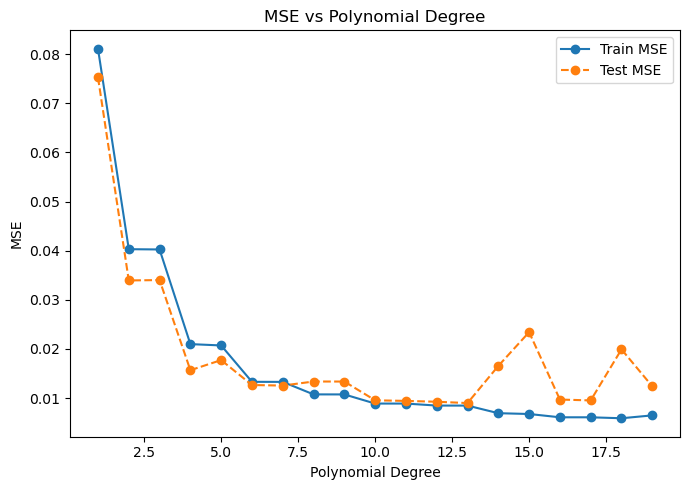

In [23]:
import numpy as np
import matplotlib.pyplot as plt

n_points = 100
x = np.linspace(-1, 1, n_points).reshape(-1, 1)

y_true = runge_function(x).ravel()

y = runge_noisy(x, noise = 0.1).ravel()

# split & scale as before
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)

degrees = range(1, 20)
mse_train, mse_test = [], []

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test  = design_matrix(x_test_scaled,  d)

    beta = ols_fit(X_train, y_train)

    y_train_pred = predict(X_train, beta)
    y_test_pred  = predict(X_test,  beta)

    mse_train.append(mse(y_train, y_train_pred))
    mse_test.append(mse(y_test,  y_test_pred))

plt.figure(figsize=(7,5))
plt.plot(degrees, mse_train, 'o-', label="Train MSE")
plt.plot(degrees, mse_test,  'o--', label="Test MSE")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title("MSE vs Polynomial Degree")
plt.legend()
plt.tight_layout()
plt.show()


The figure below imitates Fig. 2.11 of Hastie, Tibshirani, and Friedman. It is a U shaped curve representing high test error at low numbers of polynomial degree, due to high bias. The low variance at low polynomial degrees is seen by the Train and Test MSE being close. At high polynomial degrees, There is high variance resulting in higher Test MSE, although Train MSE continues decreasing. The Test MSE is lowest at some intermediate polynomial degree where there is low variance and low bias.

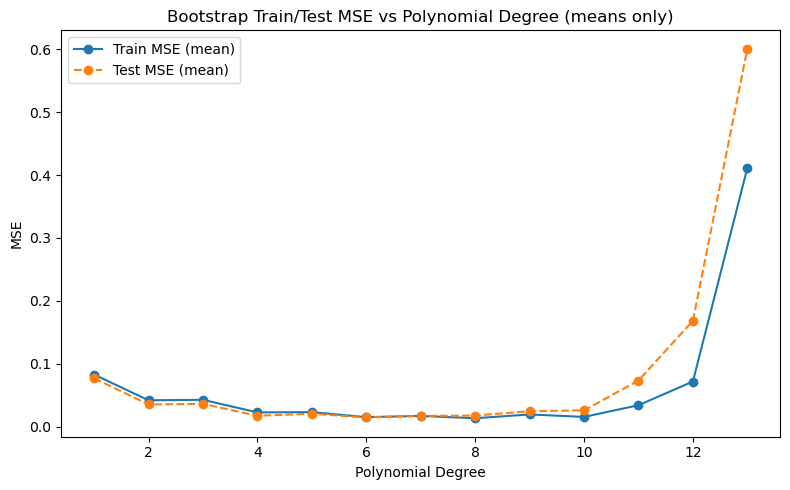

In [24]:
import numpy as np
import matplotlib.pyplot as plt


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)
degrees = range(1, 14)
B = 200                          
rng = np.random.default_rng(0)   


X_train_list = [design_matrix(x_train_scaled, d) for d in degrees]
X_test_list  = [design_matrix(x_test_scaled,  d) for d in degrees]

n_train = X_train_list[0].shape[0]
mse_train_boot = np.zeros((B, len(degrees)))
mse_test_boot  = np.zeros((B, len(degrees)))

for b in range(B):
  
    idx = rng.integers(0, n_train, size=n_train)
    yb  = y_train[idx]

    for j, _ in enumerate(degrees):
        Xb = X_train_list[j][idx]          


        beta_b = ols_fit(Xb, yb)

        
        ytr_pred_full = predict(X_train_list[j], beta_b)
        mse_train_boot[b, j] = mse(y_train, ytr_pred_full)

       
        yte_pred = predict(X_test_list[j], beta_b)
        mse_test_boot[b, j] = mse(y_test, yte_pred)


train_mean = mse_train_boot.mean(axis=0)
test_mean  = mse_test_boot.mean(axis=0)


plt.figure(figsize=(8,5))
plt.plot(list(degrees), train_mean, 'o-', label='Train MSE (mean)')
plt.plot(list(degrees), test_mean,  'o--', label='Test MSE (mean)')
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title("Bootstrap Train/Test MSE vs Polynomial Degree (means only)")
plt.legend()
plt.tight_layout()
plt.show()


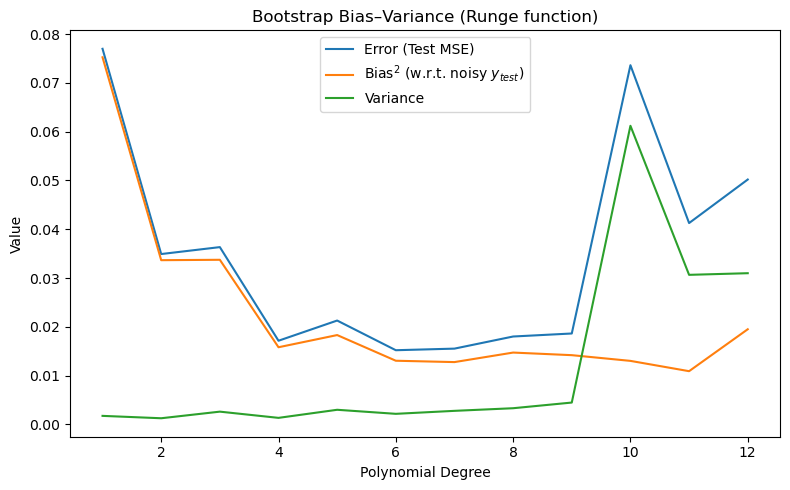

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

n_boostraps = 100  
maxdegree = 12

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)      
variance = np.zeros(maxdegree)
polydeg = np.arange(1, maxdegree+1)

rng = np.random.default_rng(0)
n_train = x_train_scaled.shape[0]
n_test = x_test_scaled.shape[0]

for idx, degree in enumerate(polydeg):
    X_train = design_matrix(x_train_scaled, degree)
    X_test = design_matrix(x_test_scaled, degree)

    y_pred = np.empty((n_test, n_boostraps))

    for b in range(n_boostraps):
        boot_idx = rng.integers(0, n_train, size=n_train)  # WITH replacement
        beta_b = ols_fit(X_train[boot_idx], y_train[boot_idx])
        y_pred[:, b] = predict(X_test, beta_b).ravel()

    mu = y_pred.mean(axis=1, keepdims=True)             
    var = y_pred.var(axis=1, ddof=1, keepdims=True)      

    variance[idx] = var.mean()
    error[idx] = np.mean((y_test.reshape(-1,1) - y_pred)**2) 
    bias[idx] = np.mean((y_test.reshape(-1,1) - mu)**2)      

# --- Plot (like your example) ---
plt.figure(figsize=(8,5))
plt.plot(polydeg, error, label='Error (Test MSE)')
plt.plot(polydeg, bias, label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value')
plt.title('Bootstrap Bias–Variance (Runge function)')
plt.legend()
plt.tight_layout()
plt.show()


The figure below shows the Bias Variance Trade-off for the Runge function using Bootstrap as a resampling method. We lower the maximum degree to 12 for easier analysis. At low degrees, the model is too rigid to learn Runge's Curvature and underfits, with a large bias that dominates the Test MSE. At the same time, variance is small since different bootstrap fits look alike. As the model complexity increases, the model captures Runge's curvature better and bias decreases. At the same time, variance increases slightly and the Test error decreases. This intermediate complexity is where Test MSE is the lowest. At higher degrees, The model starts overfitting, and different bootstrap fits differ largely. As a result, while bias is low, variance increases and domaintes the test MSE, which increases.

### part h:

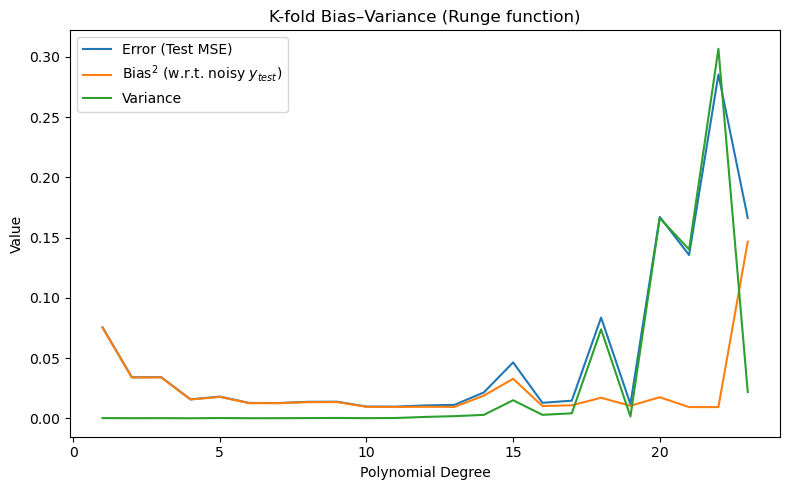

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

maxdegree = 23        
polydeg   = np.arange(1, maxdegree+1)
k         = 10                

error    = np.zeros(maxdegree)
bias     = np.zeros(maxdegree)     
variance = np.zeros(maxdegree)

kf = KFold(n_splits=k, shuffle=True, random_state=0)

n_test = x_test.shape[0]

for idx, degree in enumerate(polydeg):
    y_pred_test = np.empty((n_test, k))
    col = 0

    for tr_idx, val_idx in kf.split(x_train):
        x_tr, y_tr = x_train[tr_idx], y_train[tr_idx]

        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_test)

        X_tr = design_matrix(x_tr_s, degree)
        X_te = design_matrix(x_te_s, degree)

        beta = ols_fit(X_tr, y_tr)
        y_pred_test[:, col] = predict(X_te, beta).ravel()
        col += 1

    mu  = y_pred_test.mean(axis=1, keepdims=True)           
    var = y_pred_test.var(axis=1, ddof=1, keepdims=True)    

    variance[idx] = var.mean()
    error[idx]    = np.mean((y_test.reshape(-1,1) - y_pred_test)**2)
    bias[idx]     = np.mean((y_test.reshape(-1,1) - mu)**2)


# --- plot (same style as your bootstrap figure) ---
plt.figure(figsize=(8,5))
plt.plot(polydeg, error,    label='Error (Test MSE)')
plt.plot(polydeg, bias,     label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree'); plt.ylabel('Value')
plt.title('K-fold Bias–Variance (Runge function)')
plt.legend(); plt.tight_layout(); plt.show()


The figure above shows the Bias Variance Tradeoff using KfoldCV as a resampling method. The results are rather similar, but The Variance in K-foldCV tends to be more stable and only blows up at much higher polynomial degrees. The reason for this is because K-fold trains each model on more distinct data points as compared to bootstrap, and with more unique data for each fit, the model fluctuates less leading to lower variance.


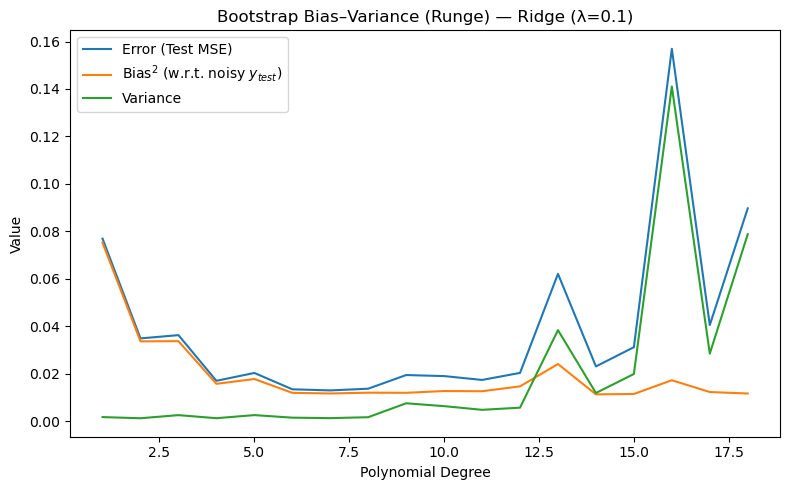

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


n_boostraps = 100   
maxdegree   = 18 
lam         = 0.1  

error    = np.zeros(maxdegree)
bias     = np.zeros(maxdegree)      
variance = np.zeros(maxdegree)
polydeg  = np.arange(1, maxdegree+1)

rng = np.random.default_rng(0)
n_train = x_train_scaled.shape[0]
n_test  = x_test_scaled.shape[0]

for idx, degree in enumerate(polydeg):
    X_train = design_matrix(x_train_scaled, degree)
    X_test  = design_matrix(x_test_scaled,  degree)

    y_pred = np.empty((n_test, n_boostraps))

    for b in range(n_boostraps):
        boot_idx = rng.integers(0, n_train, size=n_train)
        beta_b = ridge_reg(X_train[boot_idx], y_train[boot_idx], lam)
        y_pred[:, b] = predict(X_test, beta_b).ravel()

    mu  = y_pred.mean(axis=1, keepdims=True)              
    var = y_pred.var(axis=1, ddof=1, keepdims=True)       


    variance[idx] = var.mean()
    error[idx]    = np.mean((y_test.reshape(-1,1) - y_pred)**2)  
    bias[idx]     = np.mean((y_test.reshape(-1,1) - mu)**2)      

# --- Plot (same style) ---
plt.figure(figsize=(8,5))
plt.plot(polydeg, error,    label='Error (Test MSE)')
plt.plot(polydeg, bias,     label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value')
plt.title(f'Bootstrap Bias–Variance (Runge) — Ridge (λ={lam})')
plt.legend()
plt.tight_layout()
plt.show()


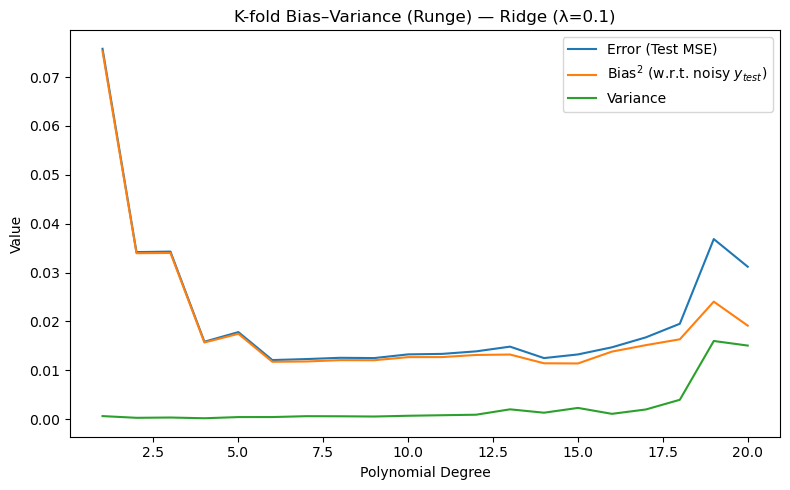

In [28]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


maxdegree = 20            
polydeg   = np.arange(1, maxdegree+1)
k         = 5                  
lam       = 0.1            

error    = np.zeros(maxdegree)
bias     = np.zeros(maxdegree)      
variance = np.zeros(maxdegree)

kf = KFold(n_splits=k, shuffle=True, random_state=0)
n_test = x_test.shape[0]

for idx, degree in enumerate(polydeg):
    y_pred_test = np.empty((n_test, k))
    col = 0

    for tr_idx, val_idx in kf.split(x_train):
        x_tr, y_tr = x_train[tr_idx], y_train[tr_idx]

        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_test)
        
        X_tr = design_matrix(x_tr_s, degree)
        X_te = design_matrix(x_te_s, degree)

        beta = ridge_reg(X_tr, y_tr, lam)
        y_pred_test[:, col] = predict(X_te, beta).ravel()
        col += 1

    mu  = y_pred_test.mean(axis=1, keepdims=True)          
    var = y_pred_test.var(axis=1, ddof=1, keepdims=True)    

    variance[idx] = var.mean()
    error[idx]    = np.mean((y_test.reshape(-1,1) - y_pred_test)**2)
    bias[idx]     = np.mean((y_test.reshape(-1,1) - mu)**2)

plt.figure(figsize=(8,5))
plt.plot(polydeg, error,    label='Error (Test MSE)')
plt.plot(polydeg, bias,     label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value')
plt.title(f'K-fold Bias–Variance (Runge) — Ridge (λ={lam})')
plt.legend()
plt.tight_layout()
plt.show()


Performing Bias Variane Trade-off analysis using Ridge, we get a rather similar result. However, because Ridge shrinks coefficient towards 0, predictions fluctuate much less and the variance rises more slowly. With Lasso Regression, the same can be observed, except that the Variance blows up at much higher degrees compared to Ridge. This is largely because Lasso zeroes out many higher order terms. As a result, we also see that the bias increases for Lasso as well, 

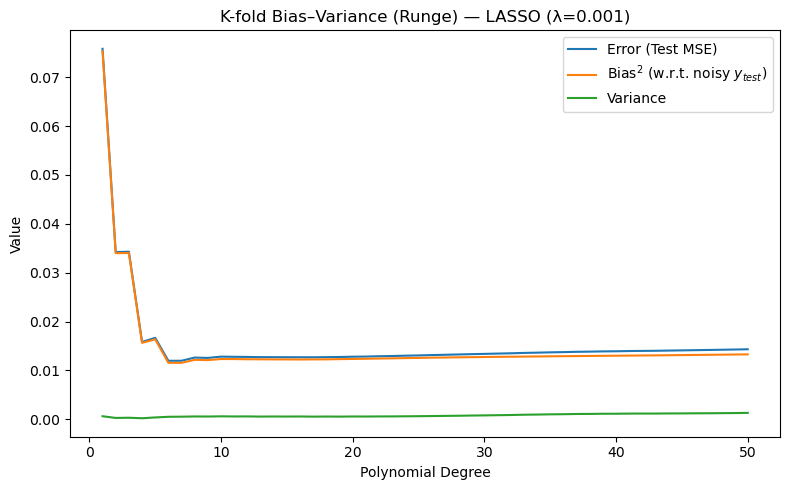

In [29]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


maxdegree = 50# degrees 1..20
polydeg   = np.arange(1, maxdegree+1)
k         = 5               
lam       = 0.001              

error    = np.zeros(maxdegree)
bias     = np.zeros(maxdegree)    
variance = np.zeros(maxdegree)

kf = KFold(n_splits=k, shuffle=True, random_state=0)
n_test = x_test.shape[0]

for idx, degree in enumerate(polydeg):

    y_pred_test = np.empty((n_test, k))
    col = 0

    for tr_idx, val_idx in kf.split(x_train):
        x_tr, y_tr = x_train[tr_idx], y_train[tr_idx]

 
        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_test)


        X_tr_raw = design_matrix(x_tr_s, degree)
        X_te_raw = design_matrix(x_te_s, degree)

    
        mu = X_tr_raw[:, 1:].mean(axis=0)
        sd = X_tr_raw[:, 1:].std(axis=0) + 1e-12

        X_tr = X_tr_raw.copy()
        X_te = X_te_raw.copy()
        if X_tr.shape[1] > 1:
            X_tr[:, 1:] = (X_tr[:, 1:] - mu) / sd
            X_te[:, 1:] = (X_te[:, 1:] - mu) / sd

       
        theta, hist, _ = lasso_ista(X_tr, y_tr, lam=lam, max_iters=10000, tol=1e-8,
                                    theta0=None, standardize_cols=False)

        
        y_pred_test[:, col] = (X_te @ theta).ravel()
        col += 1

    
    mu_pred  = y_pred_test.mean(axis=1, keepdims=True)          
    var_pred = y_pred_test.var(axis=1, ddof=1, keepdims=True)    


    variance[idx] = var_pred.mean()
    error[idx]    = np.mean((y_test.reshape(-1,1) - y_pred_test)**2)
    bias[idx]     = np.mean((y_test.reshape(-1,1) - mu_pred)**2)


plt.figure(figsize=(8,5))
plt.plot(polydeg, error,    label='Error (Test MSE)')
plt.plot(polydeg, bias,     label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value')
plt.title(f'K-fold Bias–Variance (Runge) — LASSO (λ={lam})')
plt.legend()
plt.tight_layout()
plt.show()


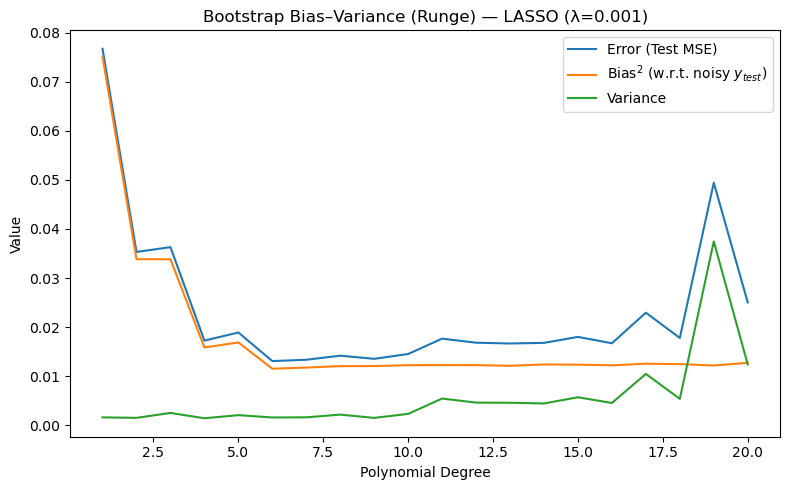

In [30]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- Settings ---
maxdegree     = 20                  
polydeg       = np.arange(1, maxdegree+1)
n_bootstraps  = 200            
lam           = 0.001             

error    = np.zeros(maxdegree)
bias     = np.zeros(maxdegree)      
variance = np.zeros(maxdegree)

rng = np.random.default_rng(0)
n_train = x_train.shape[0]
n_test  = x_test.shape[0]

for idx, degree in enumerate(polydeg):
  
    y_pred_test = np.empty((n_test, n_bootstraps))

    for b in range(n_bootstraps):

        boot_idx = rng.integers(0, n_train, size=n_train)
        x_tr, y_tr = x_train[boot_idx], y_train[boot_idx]

    
        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_test)

   
        X_tr_raw = design_matrix(x_tr_s, degree)
        X_te_raw = design_matrix(x_te_s, degree)

        X_tr = X_tr_raw.copy()
        X_te = X_te_raw.copy()
        if X_tr.shape[1] > 1:
            mu = X_tr[:, 1:].mean(axis=0)
            sd = X_tr[:, 1:].std(axis=0) + 1e-12
            X_tr[:, 1:] = (X_tr[:, 1:] - mu) / sd
            X_te[:, 1:] = (X_te[:, 1:] - mu) / sd

        
        theta, hist, _ = lasso_ista(X_tr, y_tr, lam=lam,
                                    max_iters=10000, tol=1e-8,
                                    theta0=None, standardize_cols=False)

      
        y_pred_test[:, b] = (X_te @ theta).ravel()


    mu_pred  = y_pred_test.mean(axis=1, keepdims=True)           # E[yhat | x_test]
    var_pred = y_pred_test.var(axis=1, ddof=1, keepdims=True)    # Var[yhat | x_test]


    variance[idx] = var_pred.mean()
    error[idx]    = np.mean((y_test.reshape(-1,1) - y_pred_test)**2)
    bias[idx]     = np.mean((y_test.reshape(-1,1) - mu_pred)**2)

plt.figure(figsize=(8,5))
plt.plot(polydeg, error,    label='Error (Test MSE)')
plt.plot(polydeg, bias,     label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value')
plt.title(f'Bootstrap Bias–Variance (Runge) — LASSO (λ={lam})')
plt.legend()
plt.tight_layout()
plt.show()
